In [1]:
# Importing libraries to use:
library('data.table')
library('forecast')
library('ggplot2')
library('rugarch')
library('timeSeries')
library('fImport')
library('fPortfolio')
library('GeneCycle')
library('quantmod')

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: parallel


Attaching package: 'rugarch'


The following object is masked from 'package:stats':

    sigma


Loading required package: timeDate

Loading required package: fBasics

Loading required package: fAssets

Loading required package: MASS

Loading required package: longitudinal

Loading required package: corpcor

Loading required package: fdrtool


Attaching package: 'GeneCycle'


The following object is masked from 'package:forecast':

    is.constant


Loading required package: xts

Loading required package: zoo


Attaching package: 'zoo'


The following object is masked from 'package:timeSeries':

    time<-


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric



Attaching package: 'xts'


The following objects are masked from 'package:data.table':

    first, last


Loading required package: TTR


Attaching package: 'TTR

In [2]:
# Setting plotting options
options(repr.plot.height=8, repr.plot.width=12)

In [4]:
# Reading data from csv and checking
means <- fread('data/housing_means2.csv')
head(means)

V1,mean price
<date>,<dbl>
1996-04-01,11.51426
1996-05-01,11.51562
1996-06-01,11.51695
1996-07-01,11.51824
1996-08-01,11.51958
1996-09-01,11.52106


In [5]:
# Renaming the columns
colnames(means) <- c('date', 'meanPrice')

head(means)

date,meanPrice
<date>,<dbl>
1996-04-01,11.51426
1996-05-01,11.51562
1996-06-01,11.51695
1996-07-01,11.51824
1996-08-01,11.51958
1996-09-01,11.52106


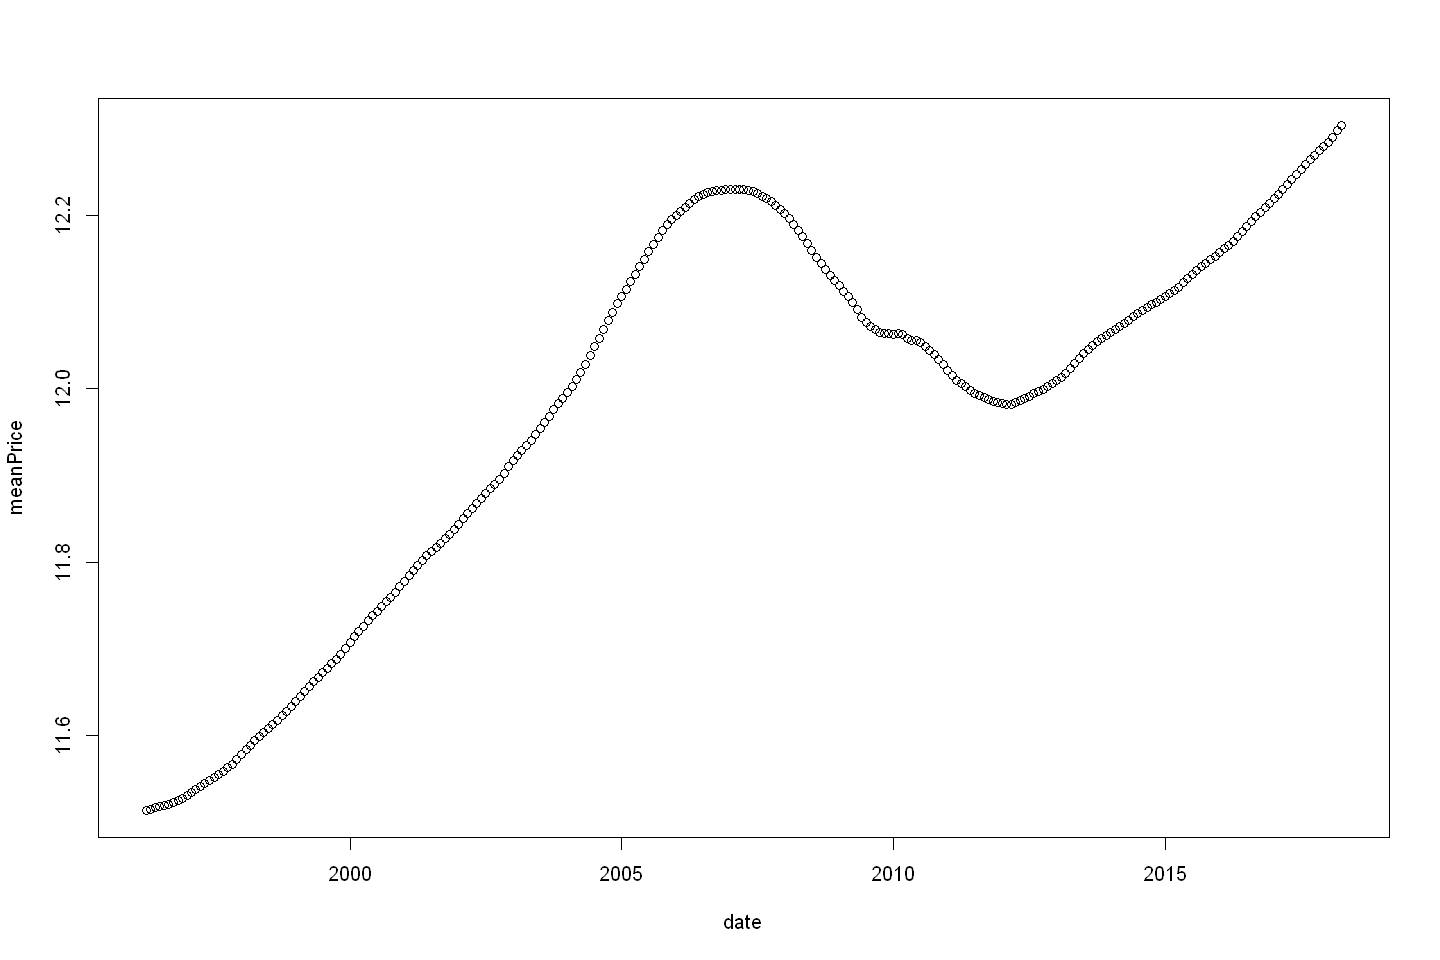

In [6]:
# Plotting the means from all zipcodes in the original dataset
plot(means)

Above we can see the behavior of the overall housing market across all zipcodes in the original dataset. Notice the large crash occurring between 2007 and 2013, caused by the Great Recession. This event, while specific in its causes, may be useful to help generate warning signs of future tumult in the markets which could be taken advantage of for asset protection.

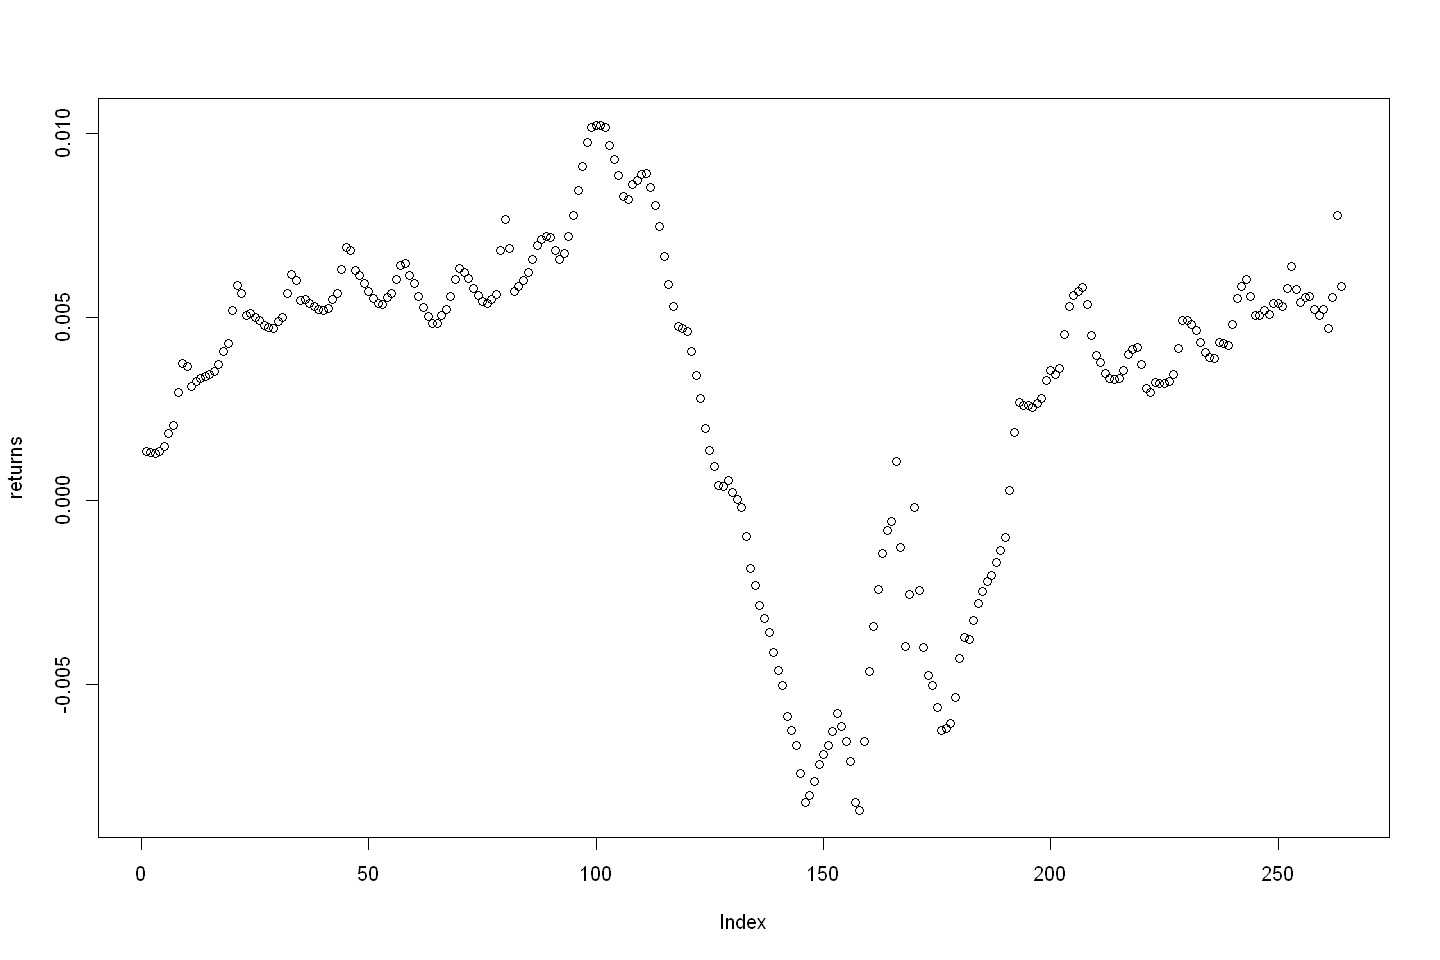

In [7]:
# Looking at the returns of the series
returns <- na.omit(diff(means$meanPrice))
plot(returns)

We can see that the returns do not seem to be stationary

In [8]:
length(means$meanPrice)

[1] 265

In [9]:
length(diff(means$meanPrice))

[1] 264

In [10]:
# Appending returns to the data.table. Note this is equivalent to the differenced log values
means$returns <- c(0, diff(means$meanPrice))
head(means)

date,meanPrice,returns
<date>,<dbl>,<dbl>
1996-04-01,11.51426,0.000000000
1996-05-01,11.51562,0.001356459
1996-06-01,11.51695,0.001328460
1996-07-01,11.51824,0.001287182
1996-08-01,11.51958,0.001339989
1996-09-01,11.52106,0.001481850


In [11]:
head(returns)

[1] 0.001356459 0.001328460 0.001287182 0.001339989 0.001481850 0.001826552

In [12]:
# A quick example of dropping rows/columns in r, where a negative sign is placed in front of the
# index of the desired row or column to drop. Below we drop the first row and second column
head(means[-1,-2])

date,returns
<date>,<dbl>
1996-05-01,0.001356459
1996-06-01,0.001328460
1996-07-01,0.001287182
1996-08-01,0.001339989
1996-09-01,0.001481850
1996-10-01,0.001826552


In [13]:
# Before converting to timeseries, must fix date type
means$date <- as.Date(means$date)

In [14]:
# Making a timeseries of class xts. Notice that the first row with the NaN is dropped
ts1 <- xts(means[-1]$returns, means[-1]$date)
colnames(ts1) <- c('returns')
head(ts1)

               returns
1996-05-01 0.001356459
1996-06-01 0.001328460
1996-07-01 0.001287182
1996-08-01 0.001339989
1996-09-01 0.001481850
1996-10-01 0.001826552

In [15]:
# Checking class of time series
class(ts1)

[1] "xts" "zoo"

In [16]:
# Making a second timeseries of class timeSeries, which is useful for other functions
ts2 <- timeSeries(ts1)
colnames(ts2) <- c('returns')
head(ts2)

GMT
               returns
1996-05-01 0.001356459
1996-06-01 0.001328460
1996-07-01 0.001287182
1996-08-01 0.001339989
1996-09-01 0.001481850
1996-10-01 0.001826552

In [17]:
class(ts2)

[1] "timeSeries"
attr(,"package")
[1] "timeSeries"

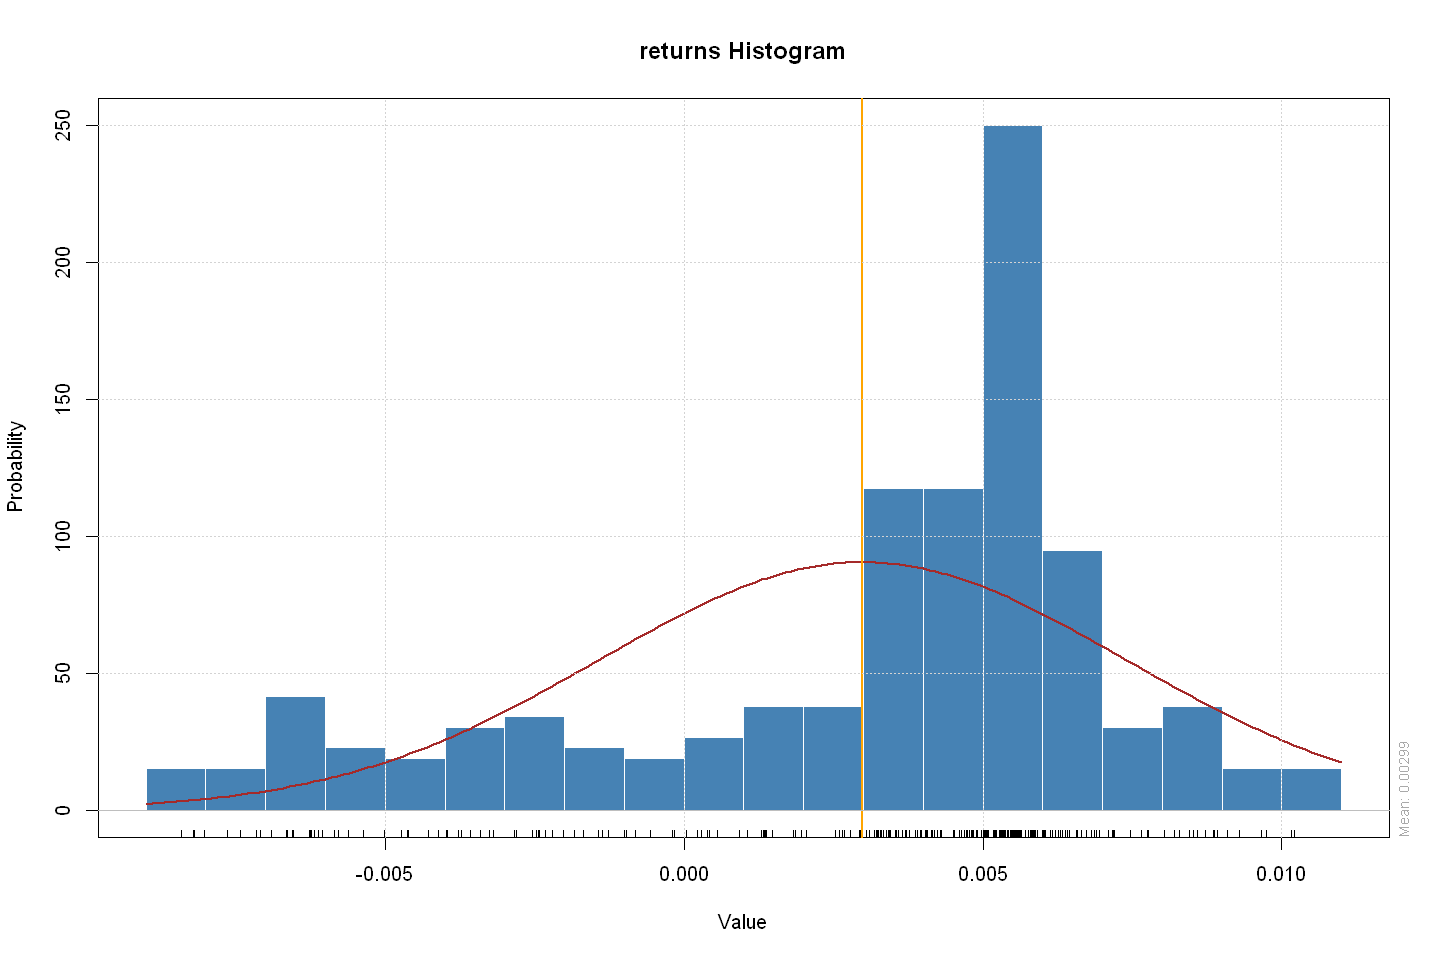

In [18]:
# For instance, this function would only accept a 'timeSeries' class object
histPlot(ts2)

In [19]:
# We can see from the histogram above that the returns have a non-zero mean and substantial 
# negative skew
print(c('Mean', mean(ts1)))
print(c('Skewness', skewness(ts1)))

[1] "Mean"                "0.00298771020889139"
[1] "Skewness"          "-0.98512422646373"


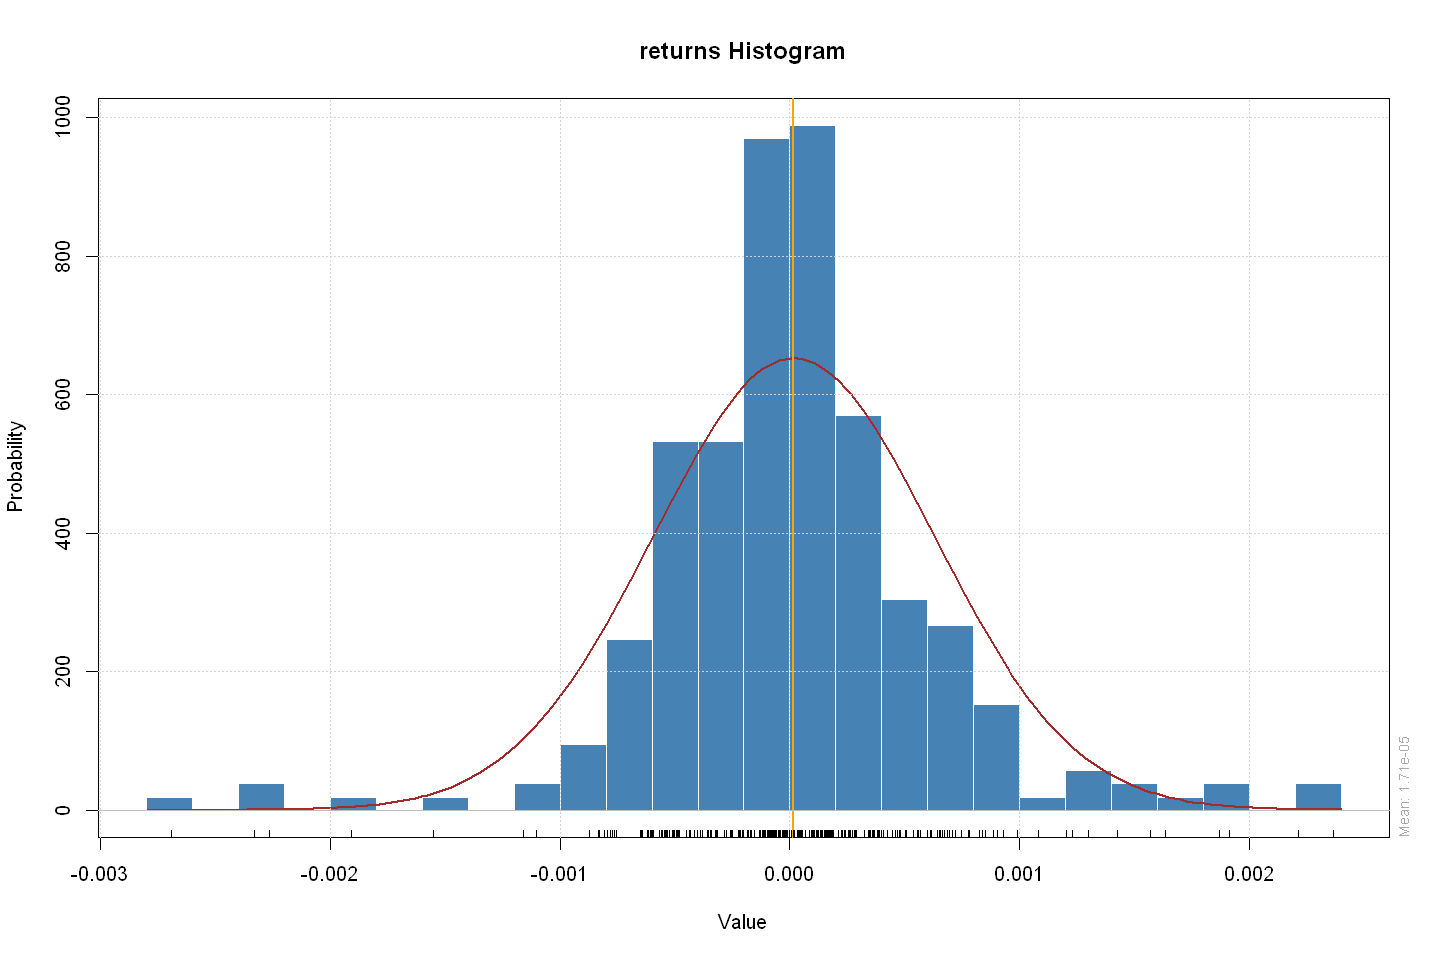

In [20]:
# Lets see how another differencing would look
histPlot(na.omit(diff(ts2)))

In [21]:
# We can see now that the mean is much closer to zero, with less skew
# It can also be seen that the distribution is extremely tall with thin tails, meaning
# a normal distribution may not be the best model distribution
print('Mean')
mean(na.omit(diff(ts1)))
print('Skew')
skewness(na.omit(diff(ts1)))

[1] "Mean"


[1] 1.706376e-05

[1] "Skew"


[1] -0.08428533
attr(,"method")
[1] "moment"

In [22]:
# The excess skew and mean were both brought closer to zero using one more order of differencing

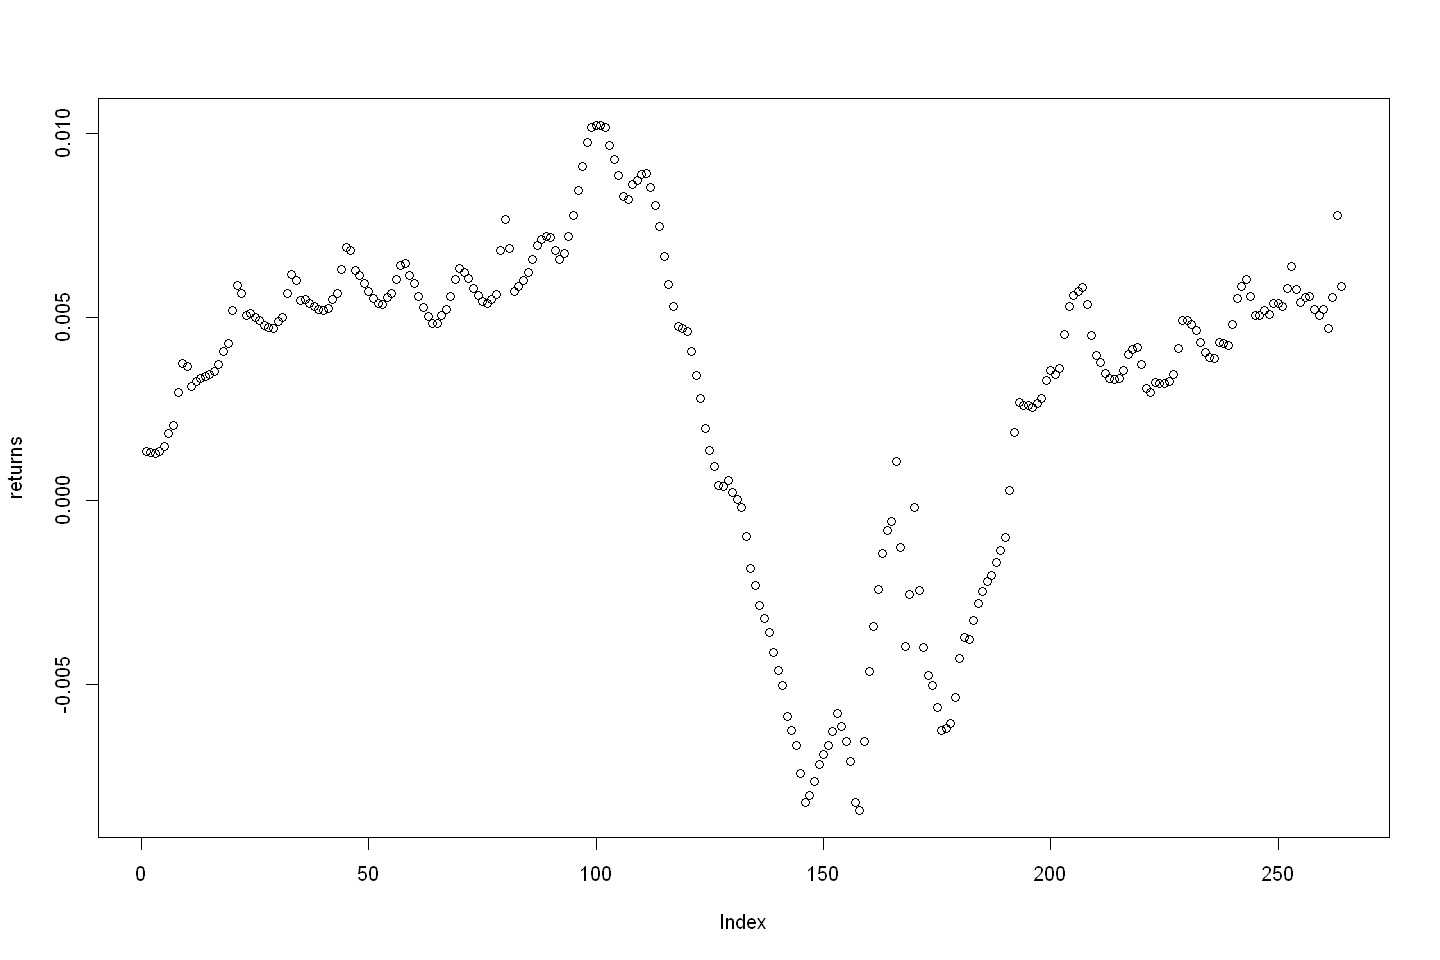

In [23]:
# A look at the returns
plot(returns)

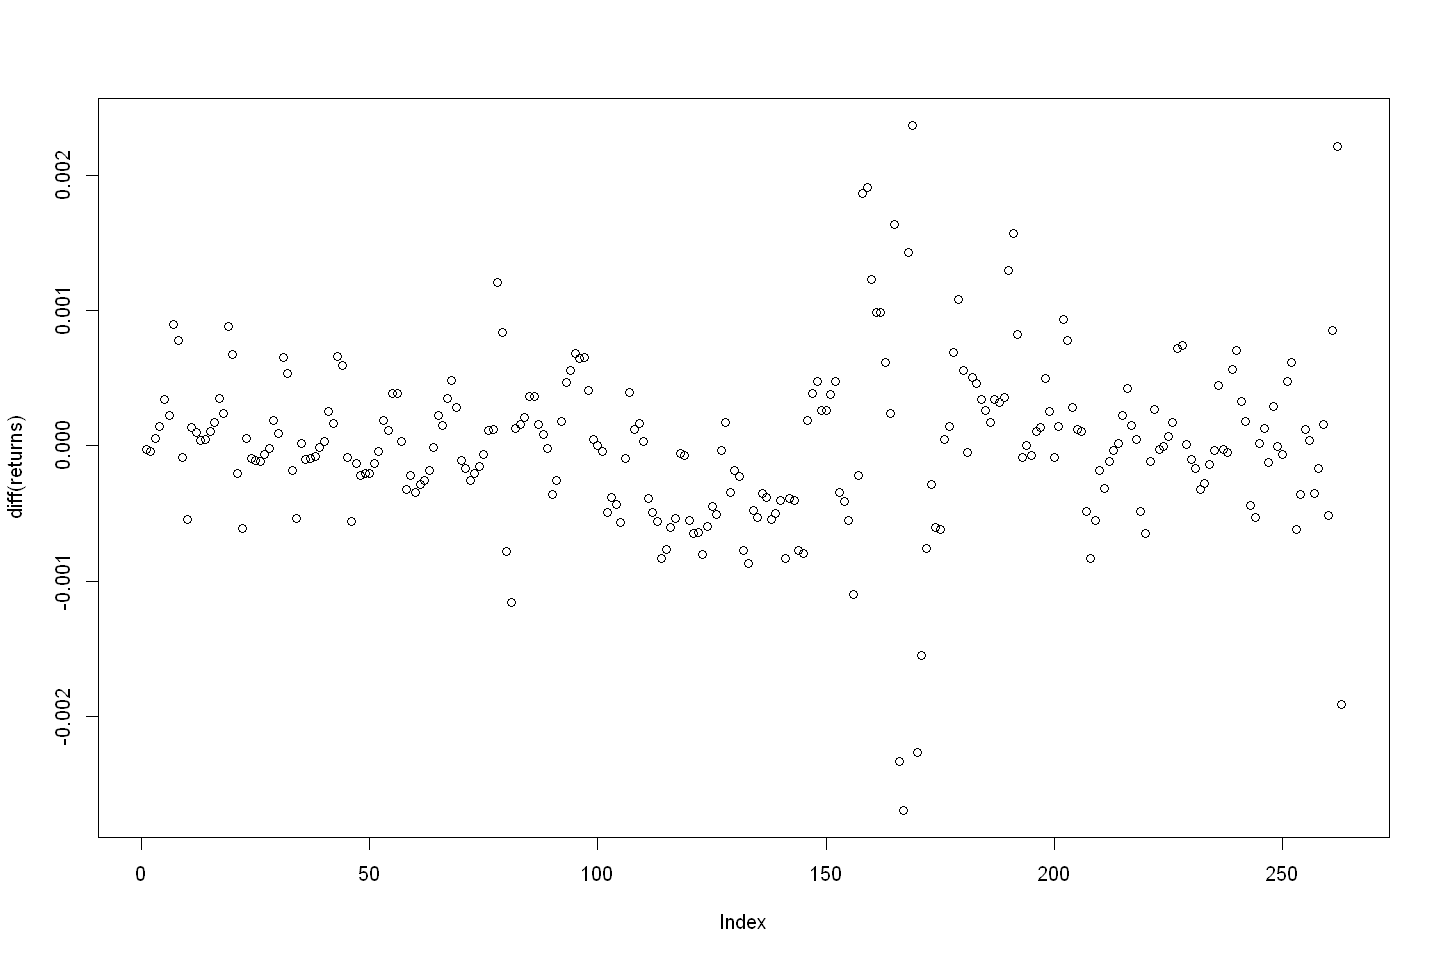

In [24]:
# Looking at differenced returns, to remove trend:
plot(diff(returns))

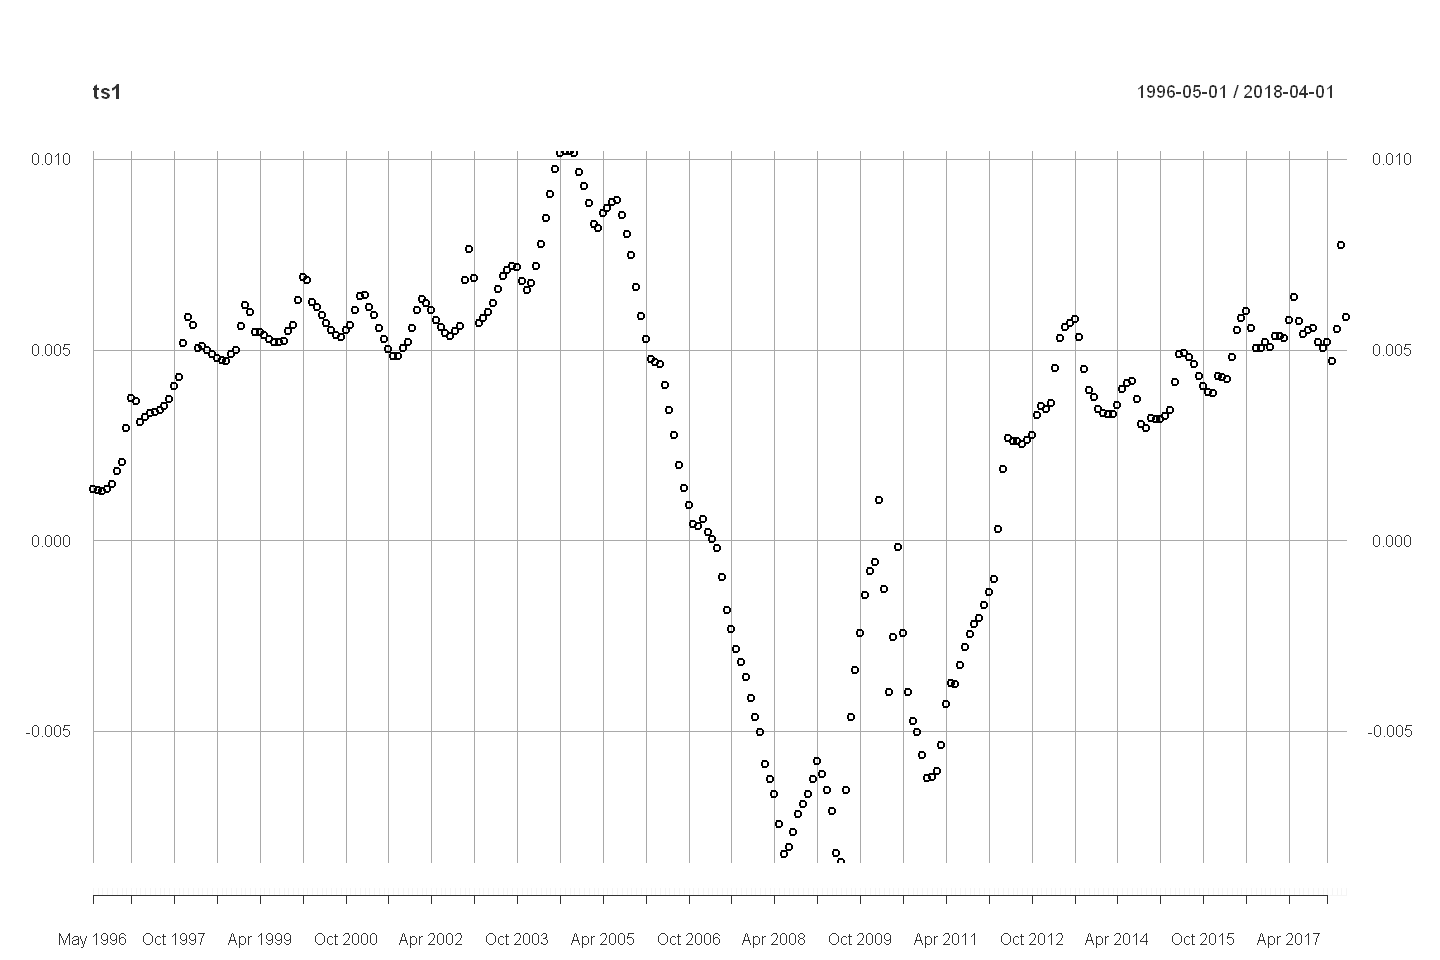

In [25]:
plot(ts1, type = 'p')

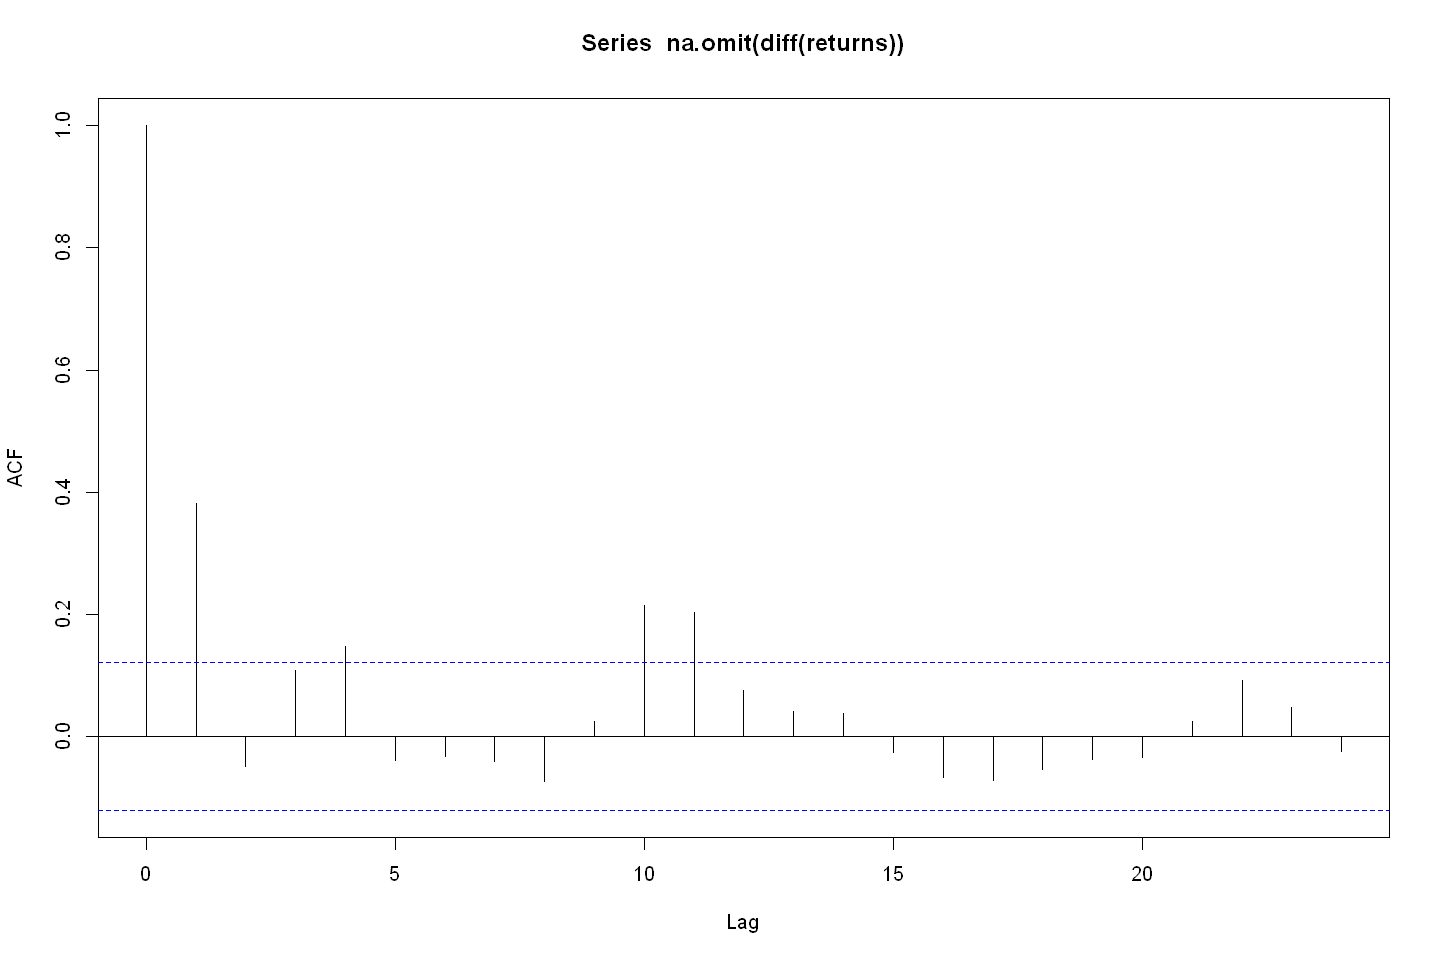

In [26]:
# A look at the ACF for differenced returns
acf(na.omit(diff(returns)))

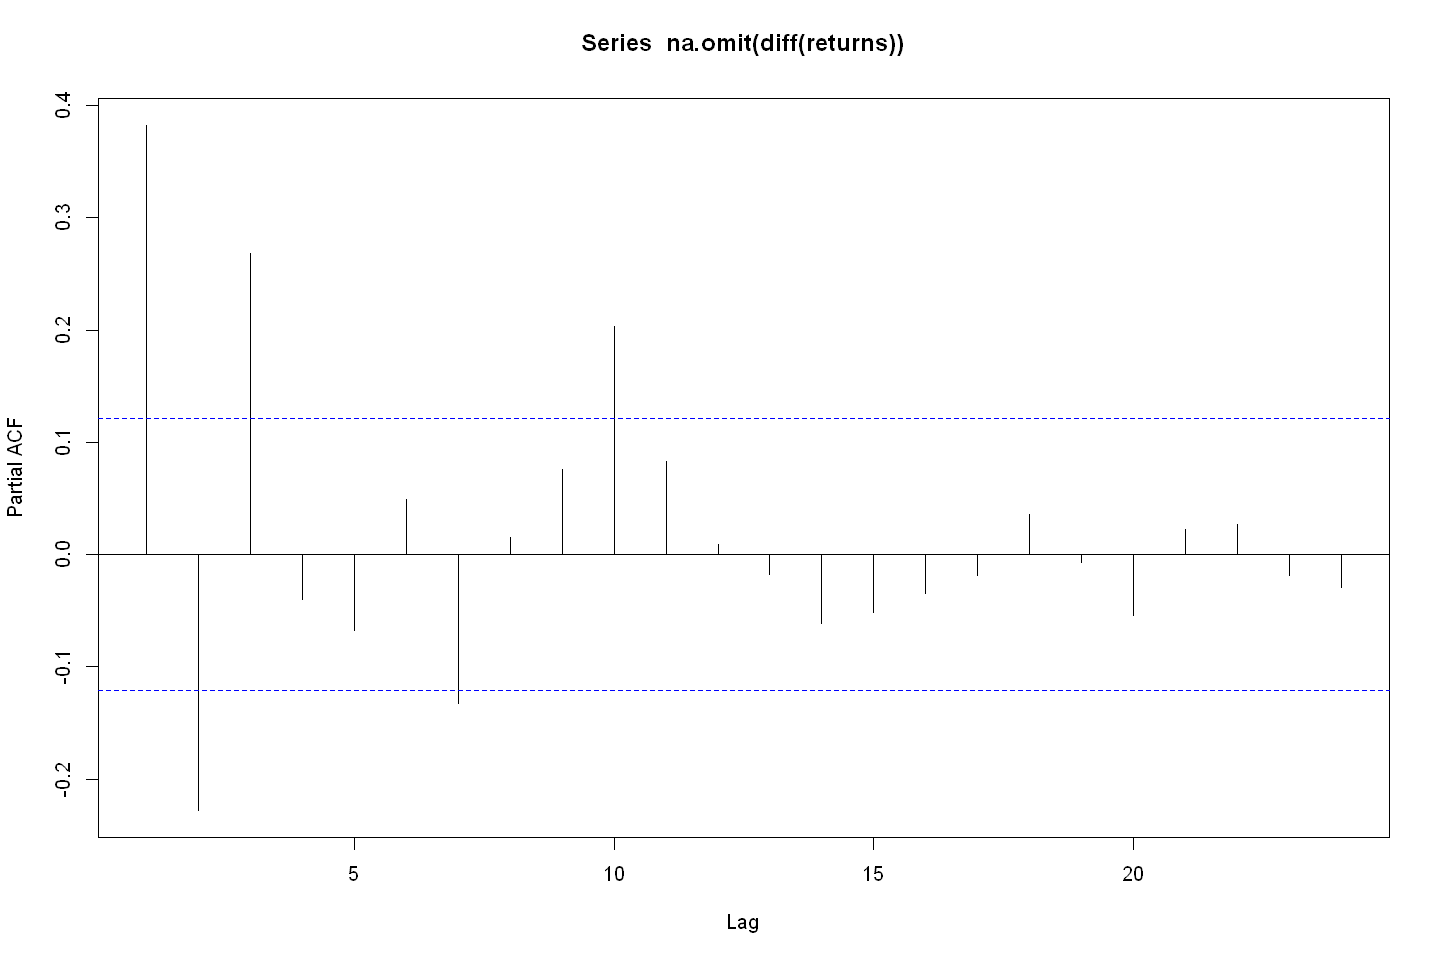

In [27]:
# A look at the PACF for differenced returns
pacf(na.omit(diff(returns)))

In [28]:
# A look at optimal arima parameters for the raw means data
auto.arima(means$meanPrice)

Series: means$meanPrice 
ARIMA(0,2,1) 

Coefficients:
         ma1
      0.6269
s.e.  0.0424

sigma^2 estimated as 1.288e-06:  log likelihood=1613.16
AIC=-3222.31   AICc=-3222.27   BIC=-3215.17

In [29]:
# Now let's see the recommendation from auto.arima() for the returns
auto.arima(ts1, seasonal = T)

Series: ts1 
ARIMA(3,1,1) with drift 

Coefficients:
         ar1      ar2     ar3     ma1  drift
      0.4437  -0.4140  0.3167  0.2229  0e+00
s.e.  0.1233   0.0894  0.0751  0.1197  1e-04

sigma^2 estimated as 2.596e-07:  log likelihood=1622.99
AIC=-3233.98   AICc=-3233.65   BIC=-3212.55

In [30]:
# A look at the arguments for ugarchspec
args(ugarchspec)

function (variance.model = list(model = "sGARCH", garchOrder = c(1, 
    1), submodel = NULL, external.regressors = NULL, variance.targeting = FALSE), 
    mean.model = list(armaOrder = c(1, 1), include.mean = TRUE, 
        archm = FALSE, archpow = 1, arfima = FALSE, external.regressors = NULL, 
        archex = FALSE), distribution.model = "norm", start.pars = list(), 
    fixed.pars = list(), ...) 
NULL

In [31]:
# Setting up specification object for the time series of returns, using the optimal ARIMA
# parameters determined above
# Note that the d=1 must be established by setting arfima=True and fixed.pars arfima=1
# Also, I will use the 'sstd' distribution model, which represents a skewed student's t dist
spec <- ugarchspec(variance.model = list(model='sGARCH',
                                          garchOrder=c(1,1)
                                         ),
                    mean.model = list(armaOrder=c(1,1),
                                      include.mean=F,
                                      archm=F,
                                      arfima=TRUE
                                     ),
                    distribution.model = 'sstd',
                    fixed.pars = list(arfima=1,
                                      #ar5=0,
                                      #ma3=0,
                                      #ma7=0,
                                      omega=0
                                     )
                   )

In [32]:
args(ugarchfit)

function (spec, data, out.sample = 0, solver = "solnp", solver.control = list(), 
    fit.control = list(stationarity = 1, fixed.se = 0, scale = 0, 
        rec.init = "all", trunclag = 1000), numderiv.control = list(grad.eps = 1e-04, 
        grad.d = 1e-04, grad.zero.tol = sqrt(.Machine$double.eps/7e-07), 
        hess.eps = 1e-04, hess.d = 0.1, hess.zero.tol = sqrt(.Machine$double.eps/7e-07), 
        r = 4, v = 2), ...) 
NULL

In [33]:
fit <- ugarchfit(spec, ts1)

In [34]:
fit


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(1,d,1)
Distribution	: sstd 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
ar1      0.42886    0.078119   5.4898  0.0e+00
ma1      0.45186    0.064336   7.0234  0.0e+00
arfima   1.00000          NA       NA       NA
omega    0.00000          NA       NA       NA
alpha1   0.15025    0.035155   4.2738  1.9e-05
beta1    0.84875    0.032930  25.7748  0.0e+00
skew     0.99433    0.059700  16.6554  0.0e+00
shape    4.31755    0.715089   6.0378  0.0e+00

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
ar1      0.42886    0.105712   4.0569 0.000050
ma1      0.45186    0.072351   6.2453 0.000000
arfima   1.00000          NA       NA       NA
omega    0.00000          NA       NA       NA
alpha1  


please wait...calculating quantiles...


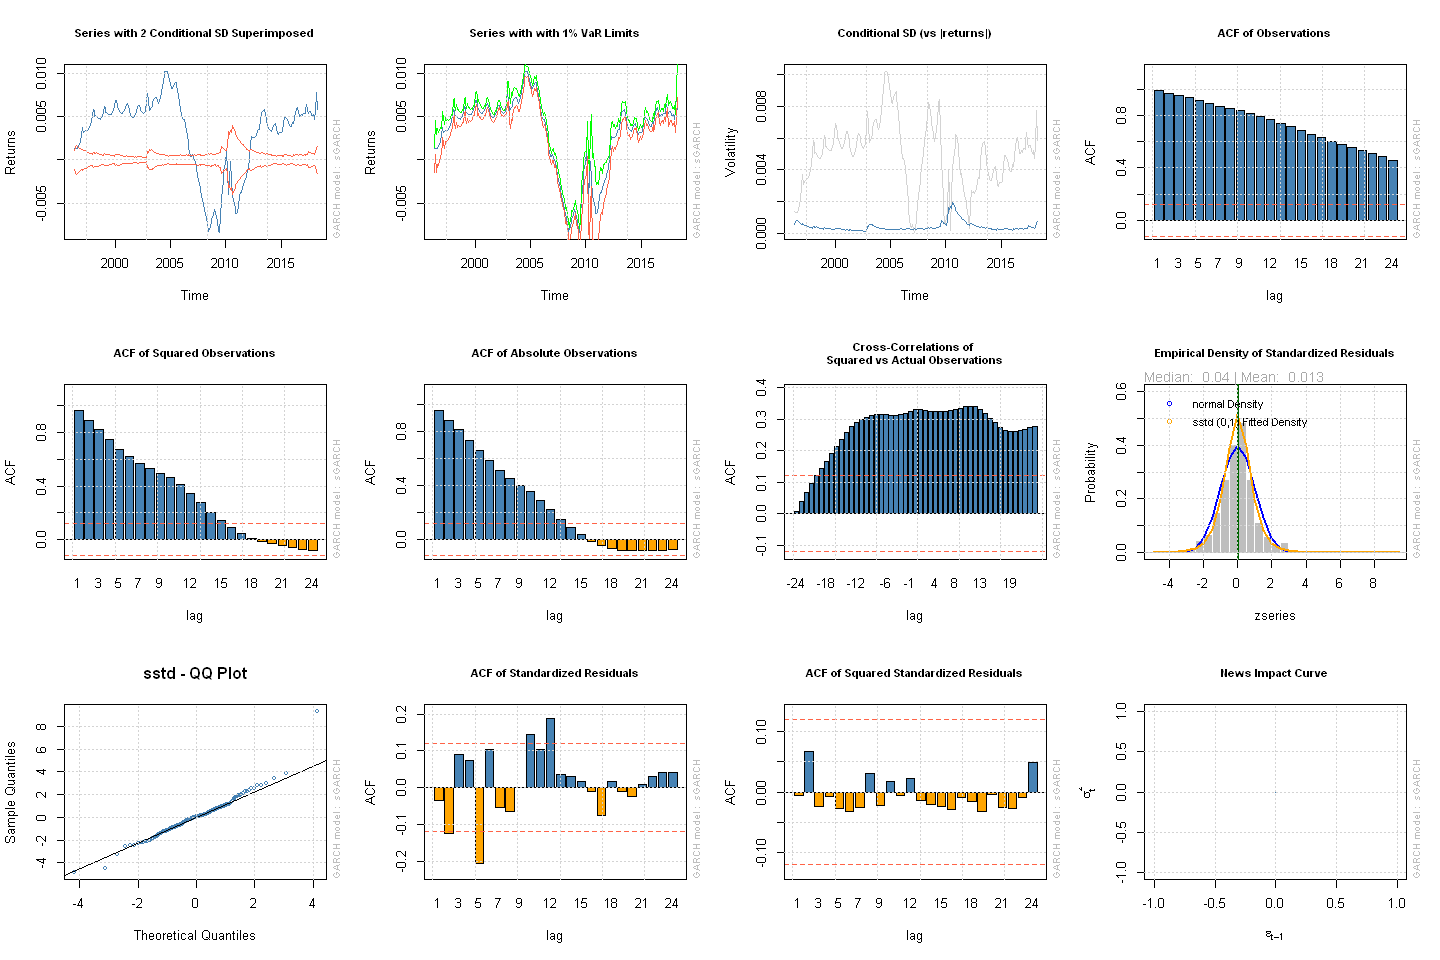

In [35]:
plot(fit, which='all')

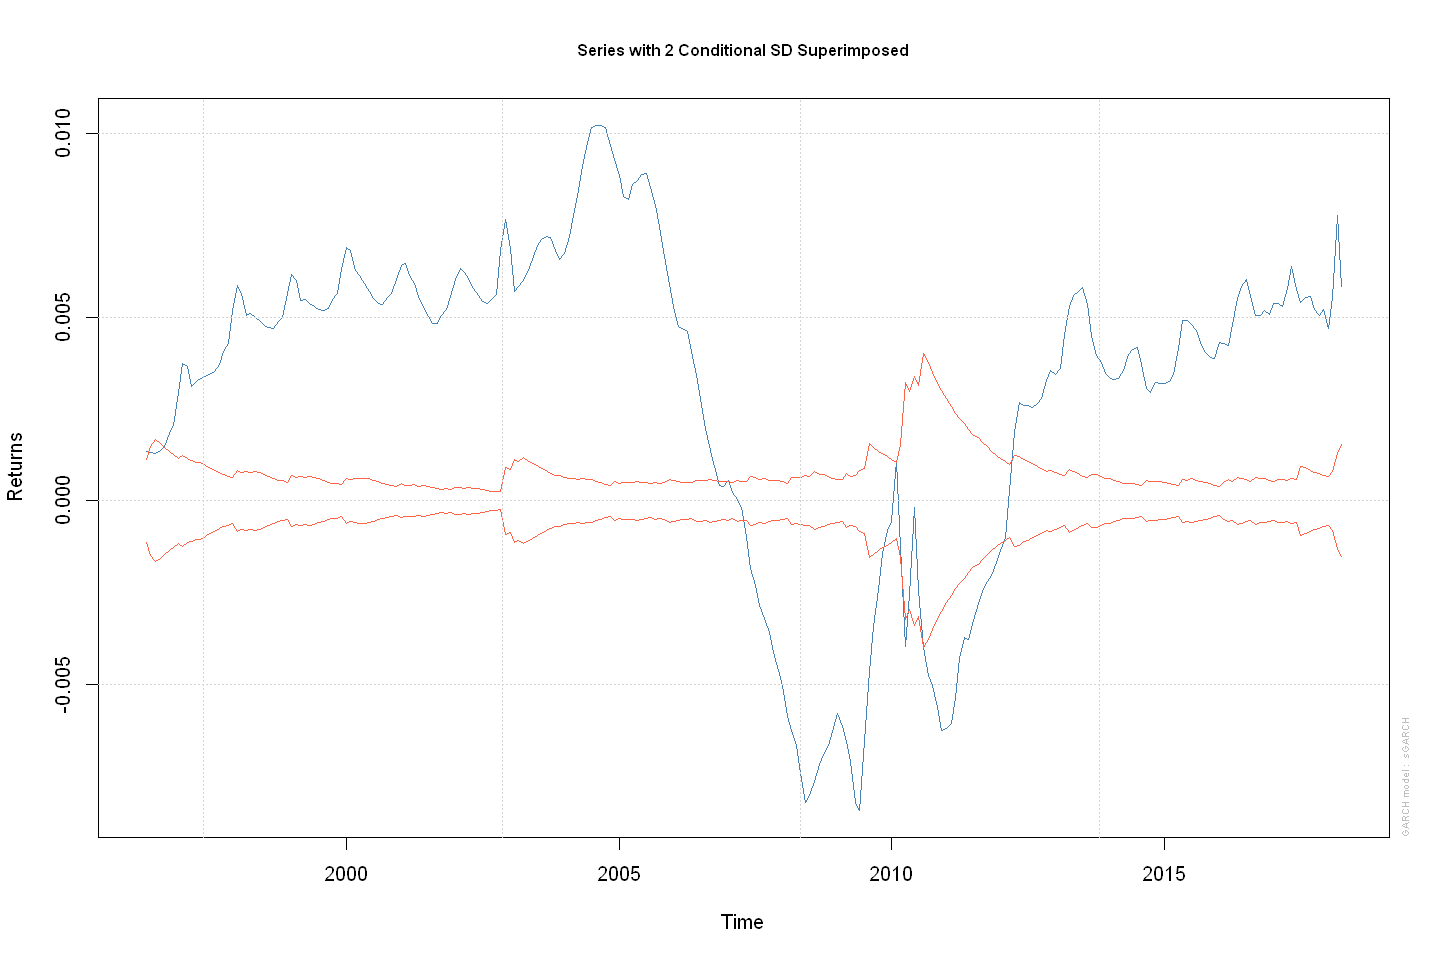

In [36]:
plot(fit, which=1)


please wait...calculating quantiles...


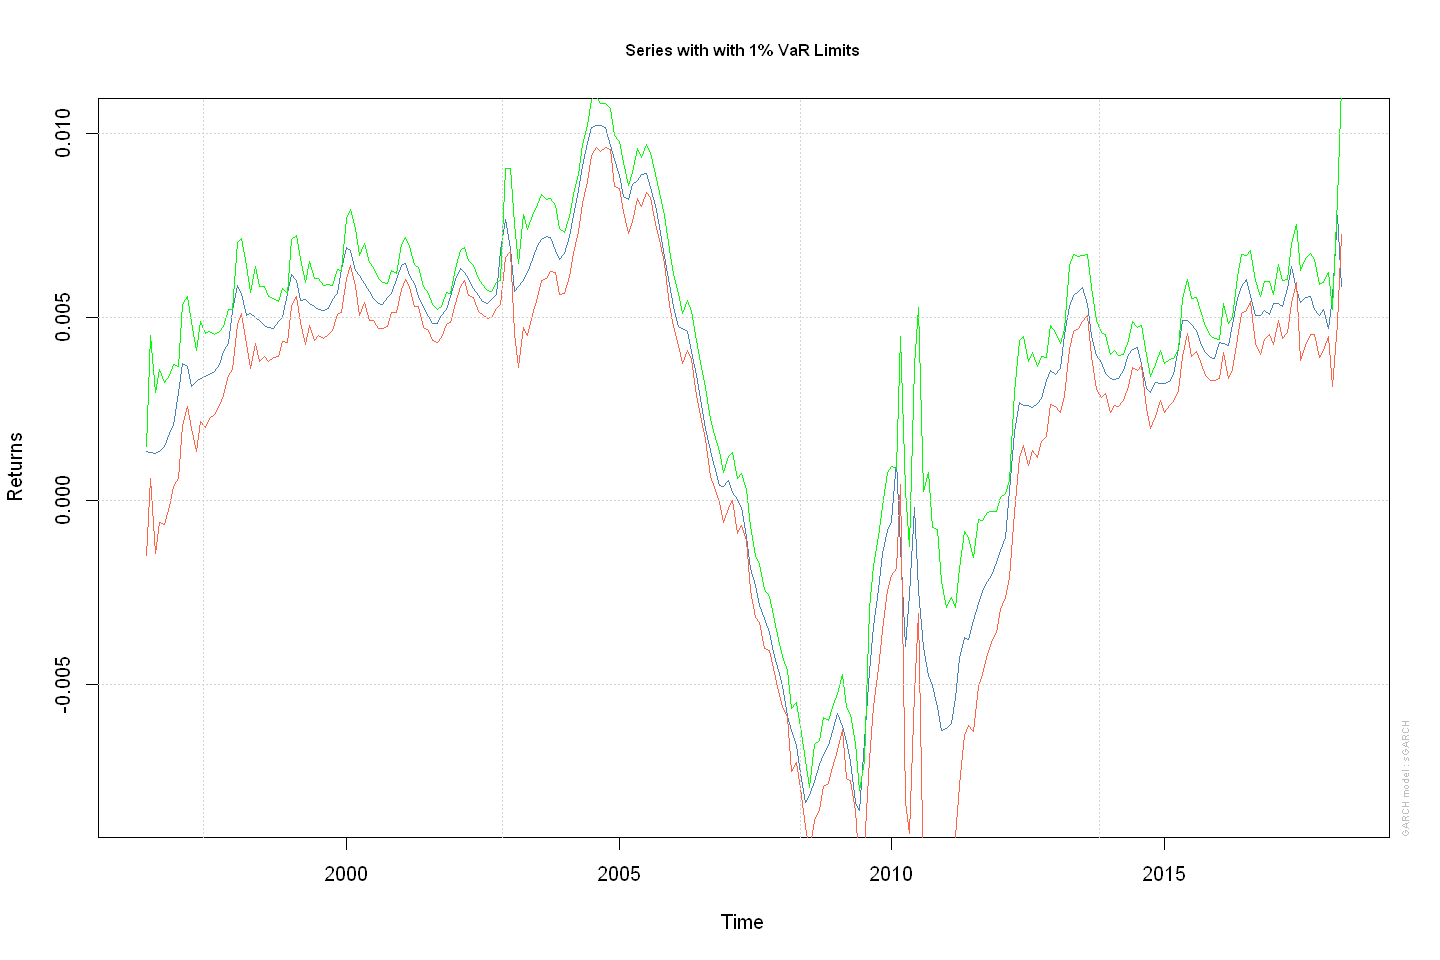

In [37]:
plot(fit, which=2)

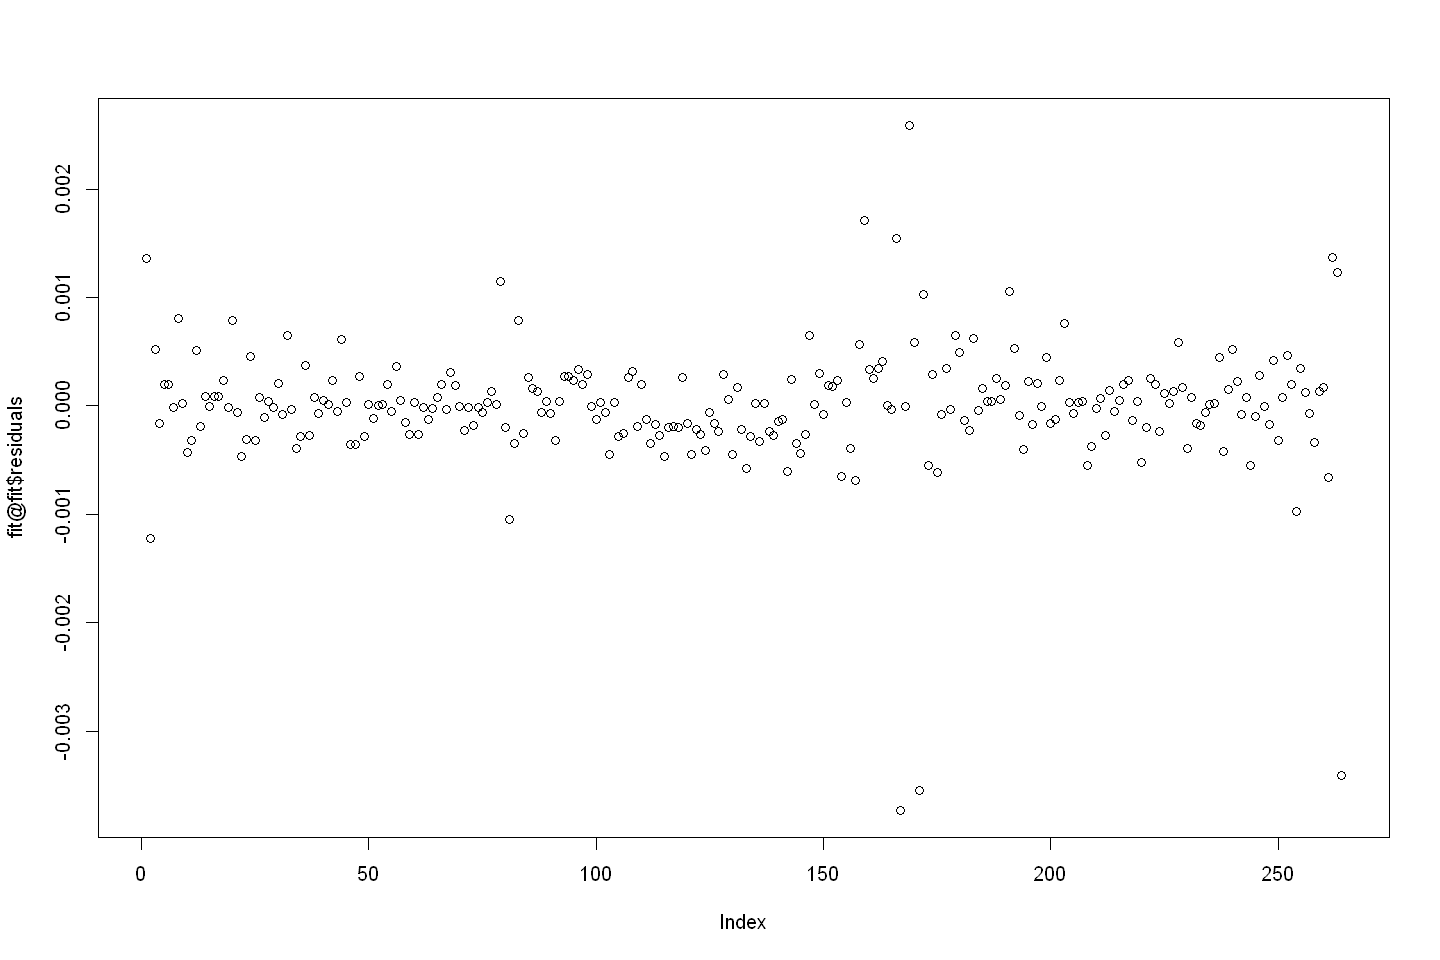

In [38]:
# A look at the residuals from the model
plot(fit@fit$residuals)

In [39]:
persistence(fit)

[1] 0.999

In [40]:
library(parallel)

In [41]:
length(ts1)

[1] 264

In [42]:
fixedspec = getspec(fit)
setfixed(fixedspec) <- as.list(coef(fit))
forecast = ugarchforecast(fixedspec, 
                          n.ahead = 1, 
                          n.roll = 263, 
                          data = ts1,
                          out.sample = 263);
forecast@forecast$seriesFor

,1996-05-01,1996-06-01,1996-07-01,1996-08-01,1996-09-01,1996-10-01,1996-11-01,1996-12-01,1997-01-01,1997-02-01,...,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01
T+1,0.00255111,0.0007639917,0.001505887,0.001287674,0.001630428,0.002062999,0.00213836,0.003702382,0.004069018,0.003416376,...,0.005404665,0.005631397,0.005545554,0.004905242,0.00502681,0.00534682,0.004172212,0.006525314,0.009255059,0.003484714


ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'lines': error in evaluating the argument 'x' in selecting a method for function 't': object 'sigs' not found


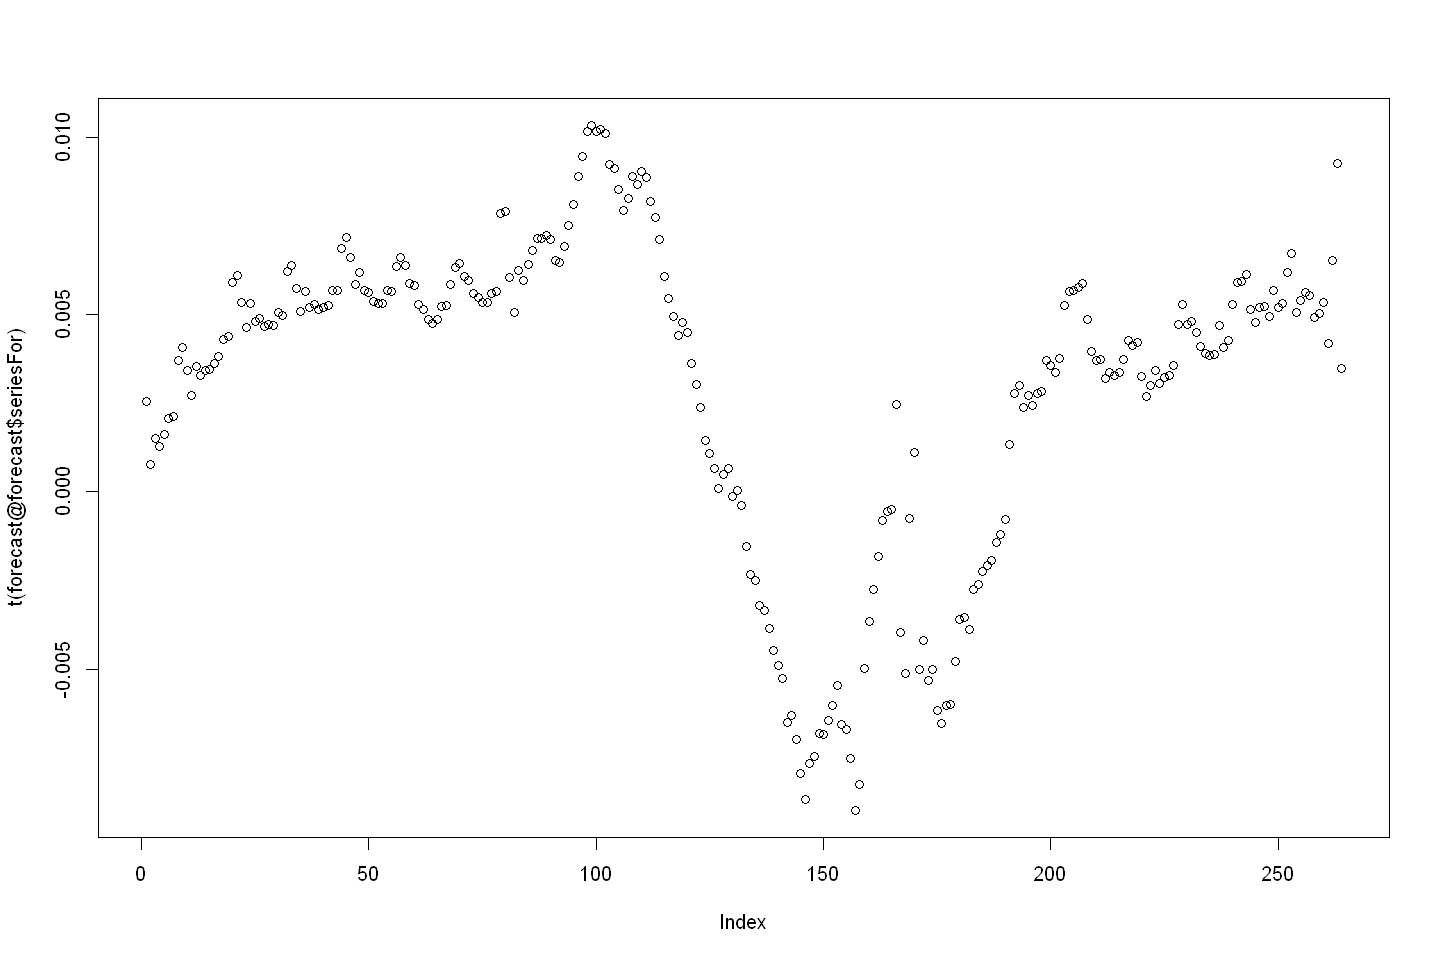

In [43]:
plot(t(forecast@forecast$seriesFor))
lines(t(sigs), col='red')

In [44]:
sigs <- forecast@forecast$sigmaFor

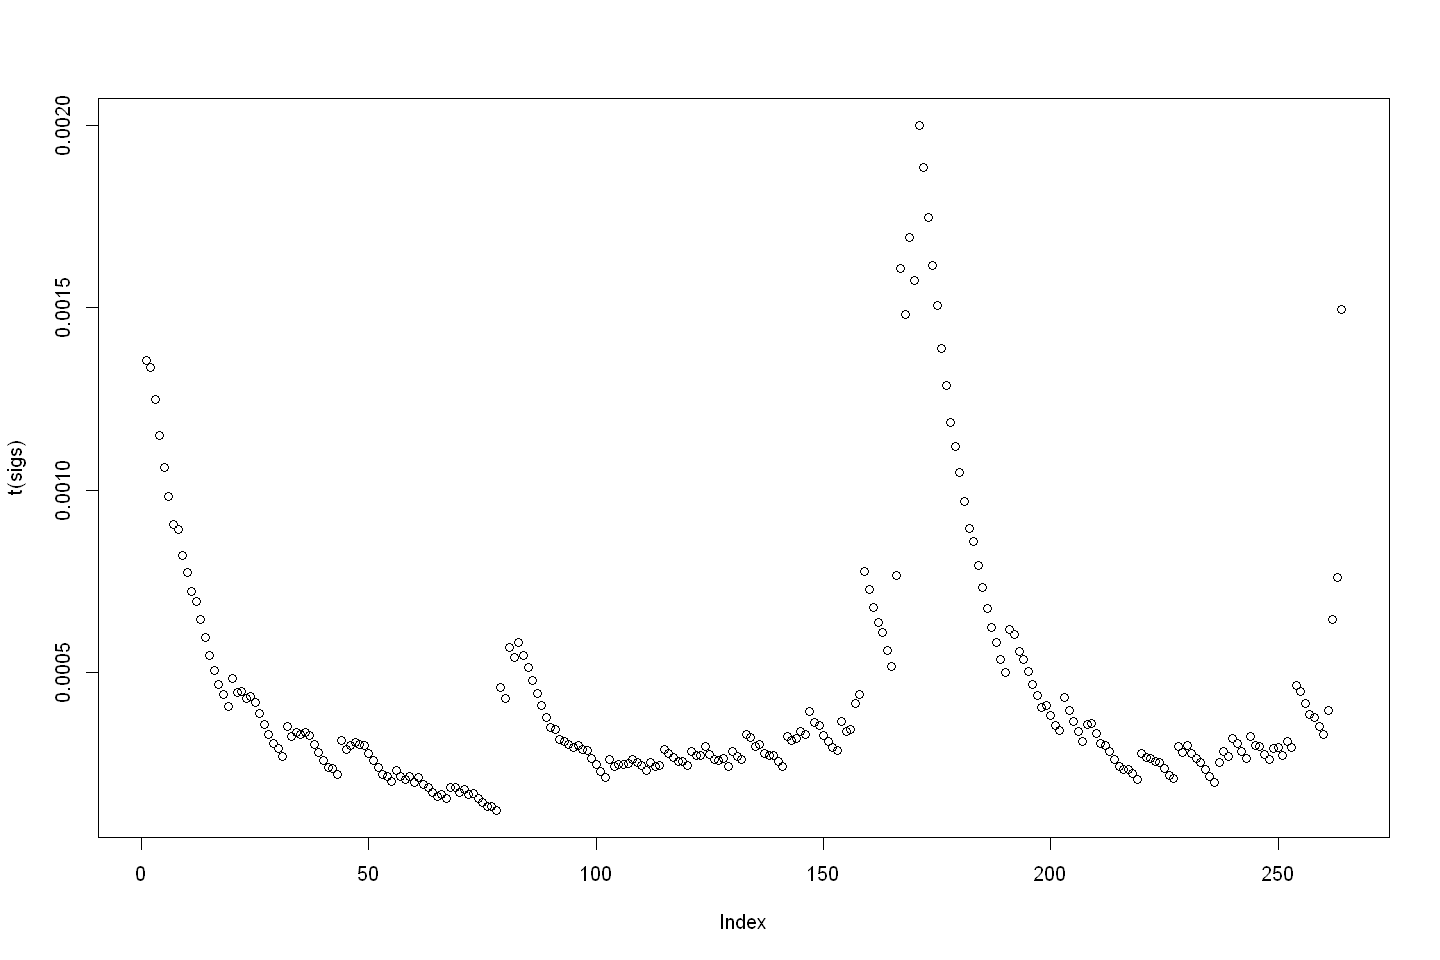

In [45]:
plot(t(sigs))

In [46]:
# We can see that this also produces the same information
fitted(forecast)

,1996-05-01,1996-06-01,1996-07-01,1996-08-01,1996-09-01,1996-10-01,1996-11-01,1996-12-01,1997-01-01,1997-02-01,...,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01
T+1,0.00255111,0.0007639917,0.001505887,0.001287674,0.001630428,0.002062999,0.00213836,0.003702382,0.004069018,0.003416376,...,0.005404665,0.005631397,0.005545554,0.004905242,0.00502681,0.00534682,0.004172212,0.006525314,0.009255059,0.003484714


In [47]:
# Transposing the forecasts we can get
fores <- t(fitted(forecast))
head(fores)

,T+1
1996-05-01,0.0025511098
1996-06-01,0.0007639917
1996-07-01,0.0015058869
1996-08-01,0.0012876737
1996-09-01,0.0016304285
1996-10-01,0.0020629991


In [48]:
tail(fores)

,T+1
2017-11-01,0.005026810
2017-12-01,0.005346820
2018-01-01,0.004172212
2018-02-01,0.006525314
2018-03-01,0.009255059
2018-04-01,0.003484714


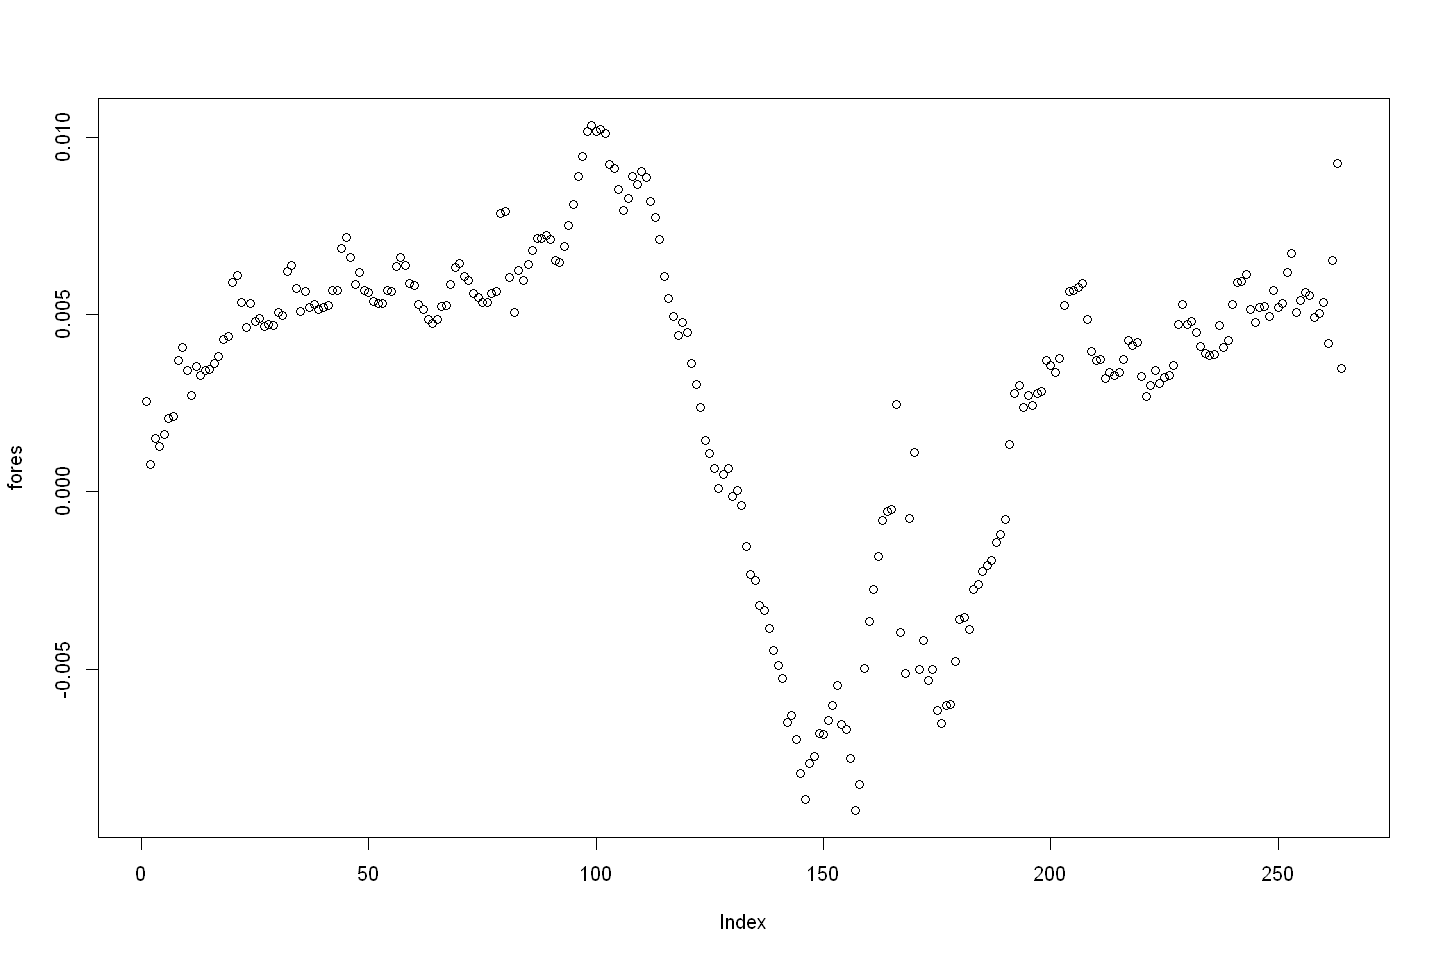

In [49]:
plot(fores)

In [50]:
# Now we need to shift the dates down one, because right now the table shows the next day's
# forecast on the date it was forecasted, indicated by the column being called T+1
# This will involve moving the dates forward by one, and dropping the last prediction
# We can get everything up to the second to last entry as such
tail(fores[-nrow(fores)])

[1] 0.004905242 0.005026810 0.005346820 0.004172212 0.006525314 0.009255059

In [51]:
# First we will shift it to a time series

In [52]:
fts <- xts(fores, means[-1]$date)

In [53]:
tail(fts[-nrow(fts)])

                   T+1
2017-10-01 0.004905242
2017-11-01 0.005026810
2017-12-01 0.005346820
2018-01-01 0.004172212
2018-02-01 0.006525314
2018-03-01 0.009255059

In [54]:
# In the next few cells we can see that dropping the first row can be done with recursive [-1]
# indexing
head(means)

date,meanPrice,returns
<date>,<dbl>,<dbl>
1996-04-01,11.51426,0.000000000
1996-05-01,11.51562,0.001356459
1996-06-01,11.51695,0.001328460
1996-07-01,11.51824,0.001287182
1996-08-01,11.51958,0.001339989
1996-09-01,11.52106,0.001481850


In [55]:
head(means[-1])

date,meanPrice,returns
<date>,<dbl>,<dbl>
1996-05-01,11.51562,0.001356459
1996-06-01,11.51695,0.001328460
1996-07-01,11.51824,0.001287182
1996-08-01,11.51958,0.001339989
1996-09-01,11.52106,0.001481850
1996-10-01,11.52288,0.001826552


In [56]:
# This will be the notation to use to get the dates we want
head(means[-1][-1])

date,meanPrice,returns
<date>,<dbl>,<dbl>
1996-06-01,11.51695,0.001328460
1996-07-01,11.51824,0.001287182
1996-08-01,11.51958,0.001339989
1996-09-01,11.52106,0.001481850
1996-10-01,11.52288,0.001826552
1996-11-01,11.52493,0.002049152


In [57]:
# Making the appropriate time series forecast list
fts2 <- xts(fores[-nrow(fores)], means[-1][-1]$date)

In [58]:
head(fts2)

                   [,1]
1996-06-01 0.0025511098
1996-07-01 0.0007639917
1996-08-01 0.0015058869
1996-09-01 0.0012876737
1996-10-01 0.0016304285
1996-11-01 0.0020629991

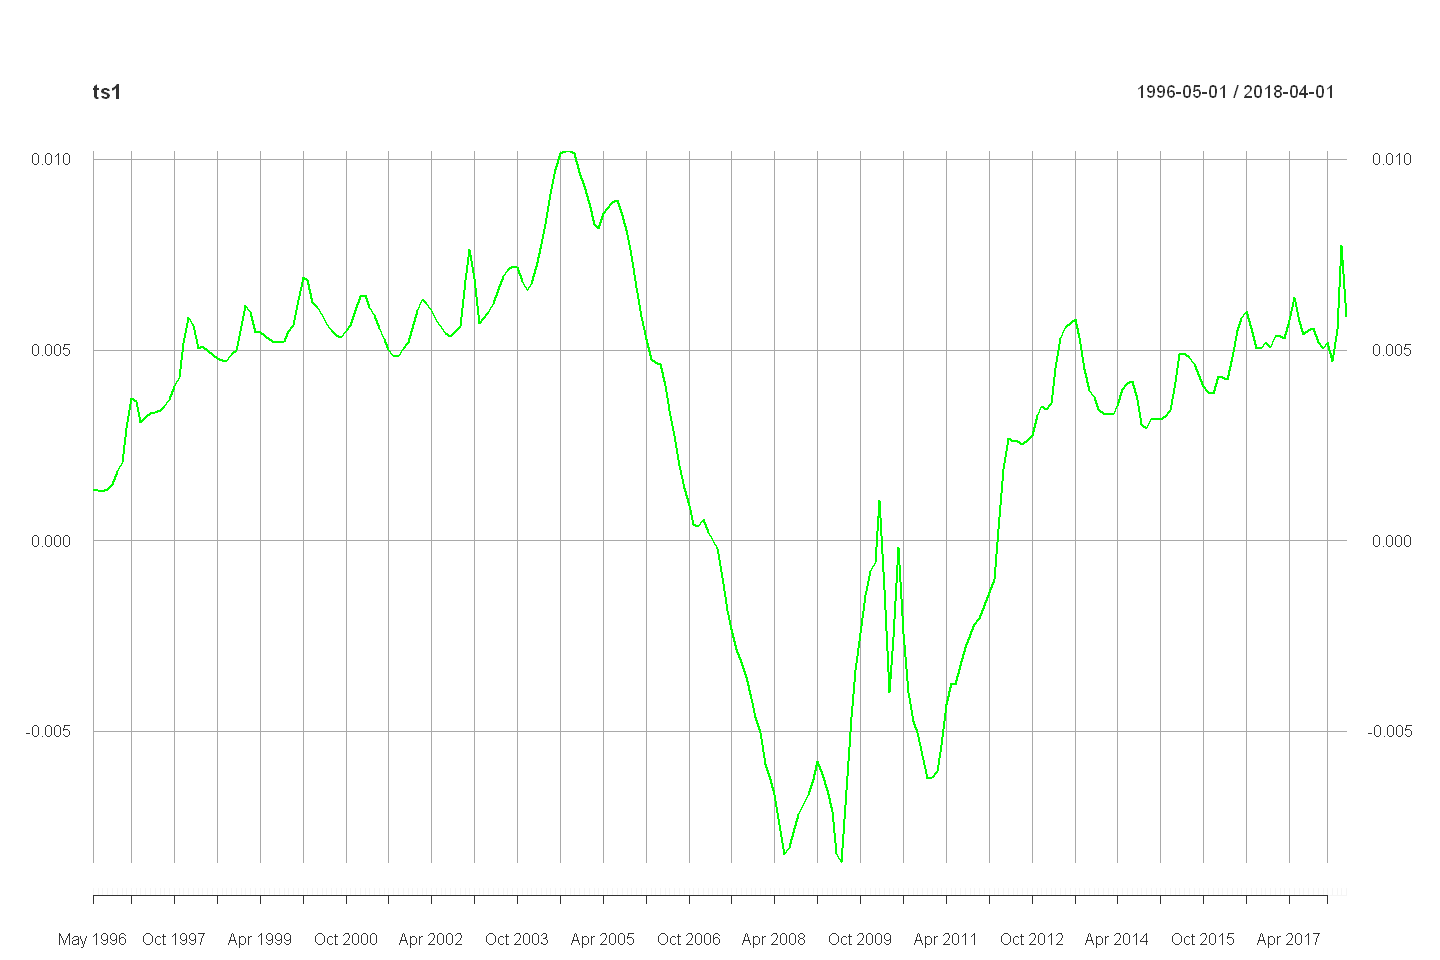

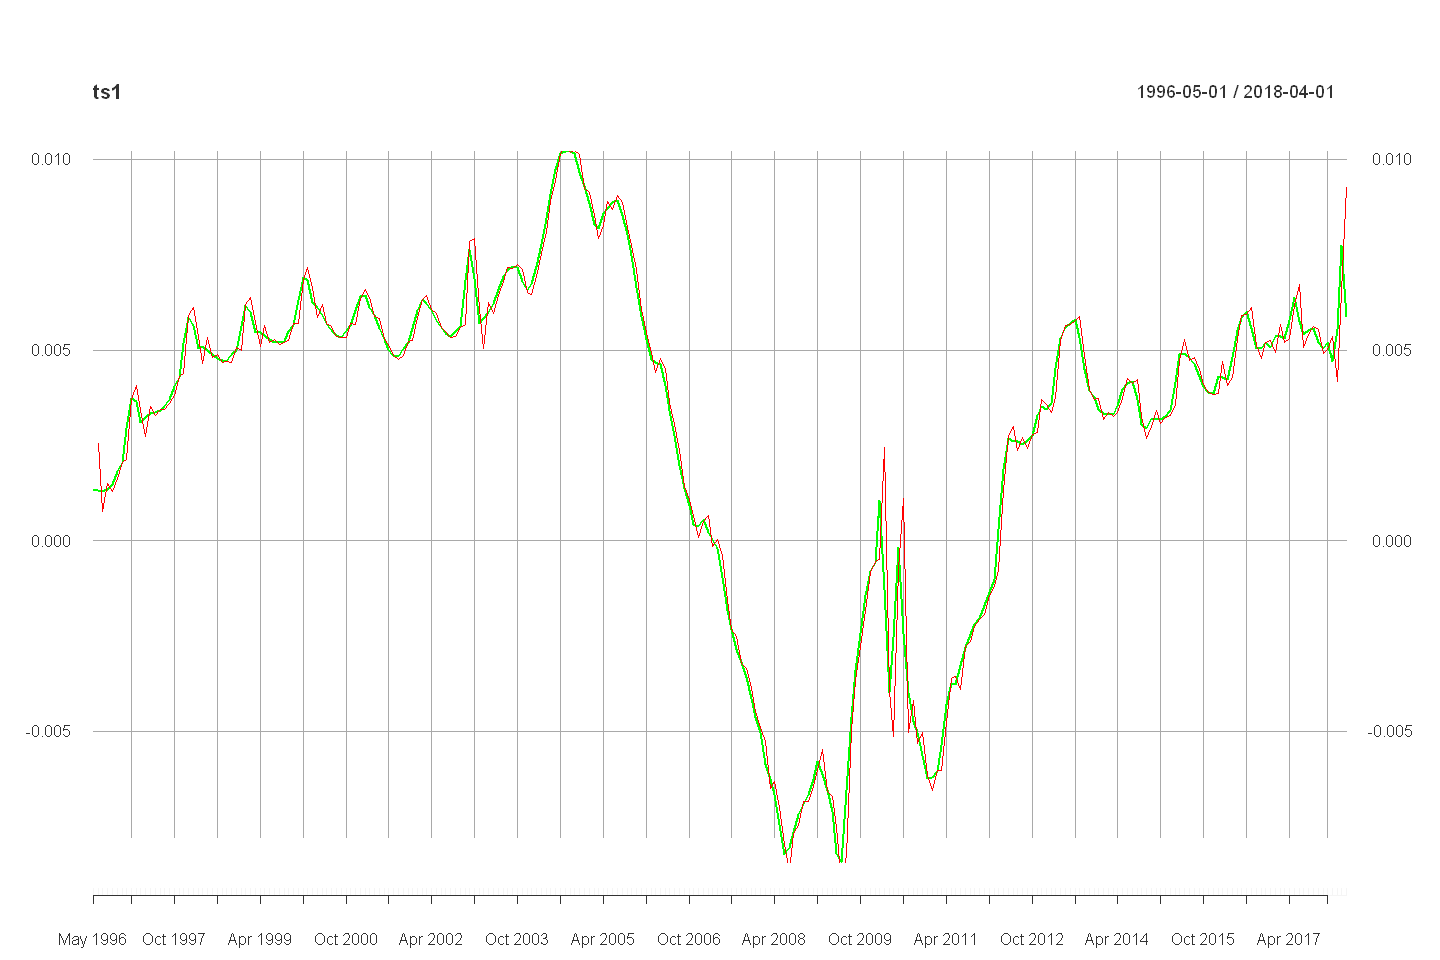

In [59]:
# We can see that the red (predictons) are close to the actual, but trailing behind the actual
# most of the time
plot(ts1, type='l', col='green')
lines(fts2, col='red')

In [60]:
args(ugarchroll)

function (spec, data, n.ahead = 1, forecast.length = 500, n.start = NULL, 
    refit.every = 25, refit.window = c("recursive", "moving"), 
    window.size = NULL, solver = "hybrid", fit.control = list(), 
    solver.control = list(), calculate.VaR = TRUE, VaR.alpha = c(0.01, 
        0.05), cluster = NULL, keep.coef = TRUE, ...) 
NULL

In [61]:
# The next cells show an easier way to show the model performance on the actual data, also
# with refitting the model as new data becomes available, with no look-ahead bias

In [62]:
#cl = makePSOCKcluster(10)
roll = ugarchroll(spec, 
                  ts1, 
                  n.start = 150, 
                  refit.every = 1,
                  refit.window = "expanding", 
                  solver = "hybrid", 
                  calculate.VaR = TRUE,
                  VaR.alpha = c(0.01, 0.05), 
                  #cluster = cl, 
                  keep.coef = TRUE)
show(roll)
#stopCluster(cl)


*-------------------------------------*
*              GARCH Roll             *
*-------------------------------------*
No.Refits		: 114
Refit Horizon	: 1
No.Forecasts	: 114
GARCH Model		: sGARCH(1,1)
Distribution	: sstd 

Forecast Density:
                Mu Sigma   Skew  Shape Shape(GIG) Realized
2008-11-01 -0.0068 4e-04 1.1056 2.8659          0  -0.0066
2008-12-01 -0.0064 3e-04 1.1100 3.5199          0  -0.0063
2009-01-01 -0.0060 3e-04 1.1352 3.8255          0  -0.0058
2009-02-01 -0.0054 3e-04 1.1122 3.5675          0  -0.0061
2009-03-01 -0.0065 3e-04 1.1146 3.8509          0  -0.0065
2009-04-01 -0.0068 3e-04 1.1095 3.1551          0  -0.0071

..........................
               Mu Sigma   Skew  Shape Shape(GIG) Realized
2017-11-01 0.0049 4e-04 0.9906 3.3396          0   0.0050
2017-12-01 0.0050 3e-04 0.9835 3.3053          0   0.0052
2018-01-01 0.0053 3e-04 0.9757 3.3175          0   0.0047
2018-02-01 0.0042 4e-04 0.9682 3.3285          0   0.0055
2018-03-01 0.0064 8e-04 0.9

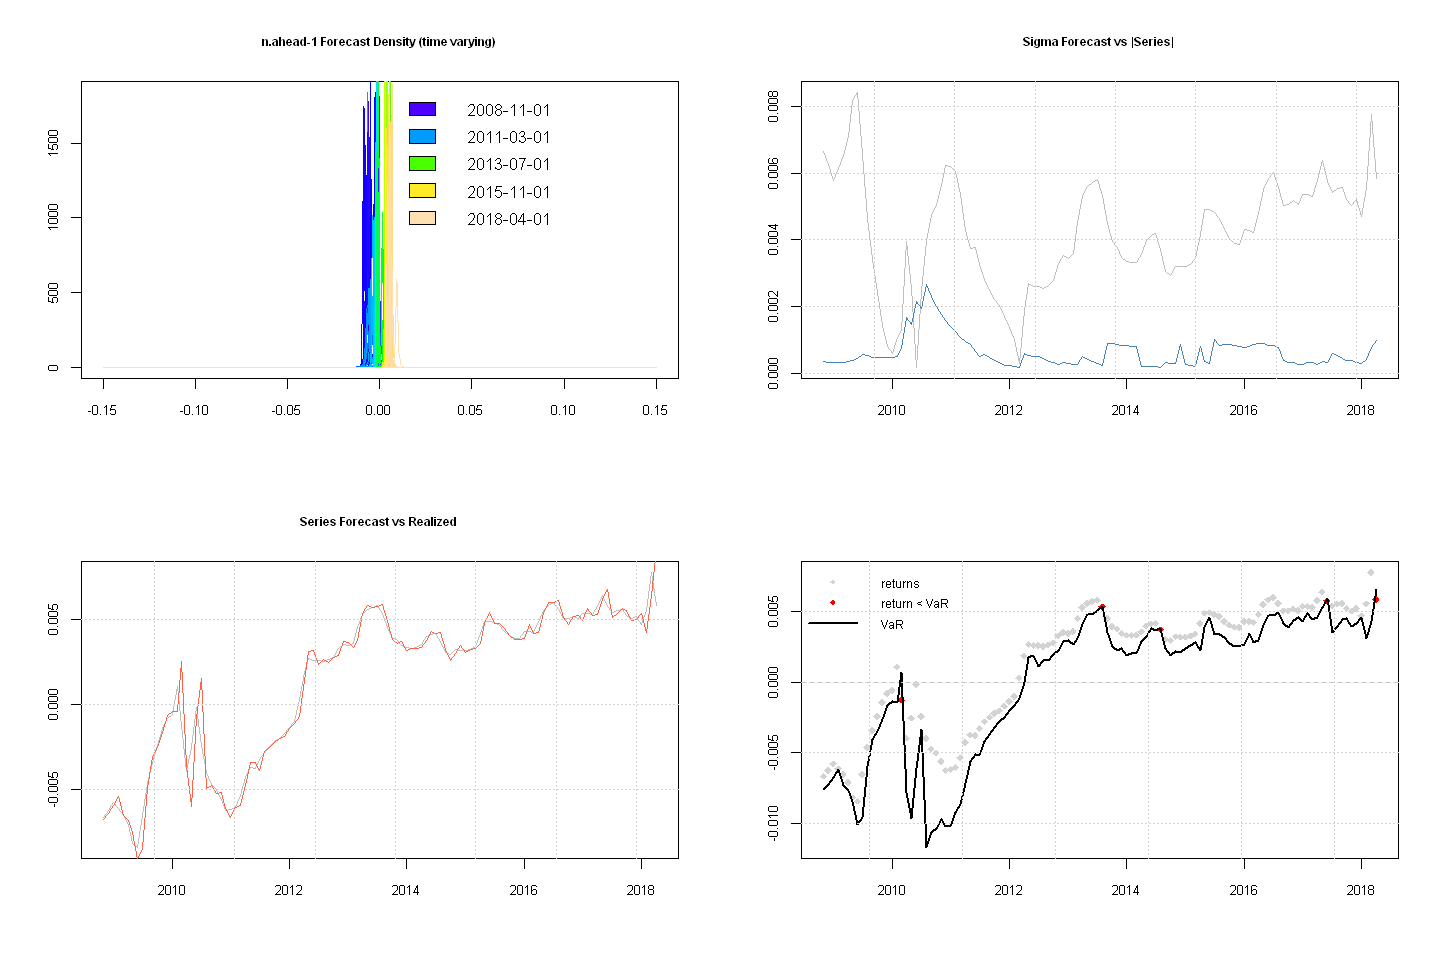

In [63]:
plot(roll, which='all')

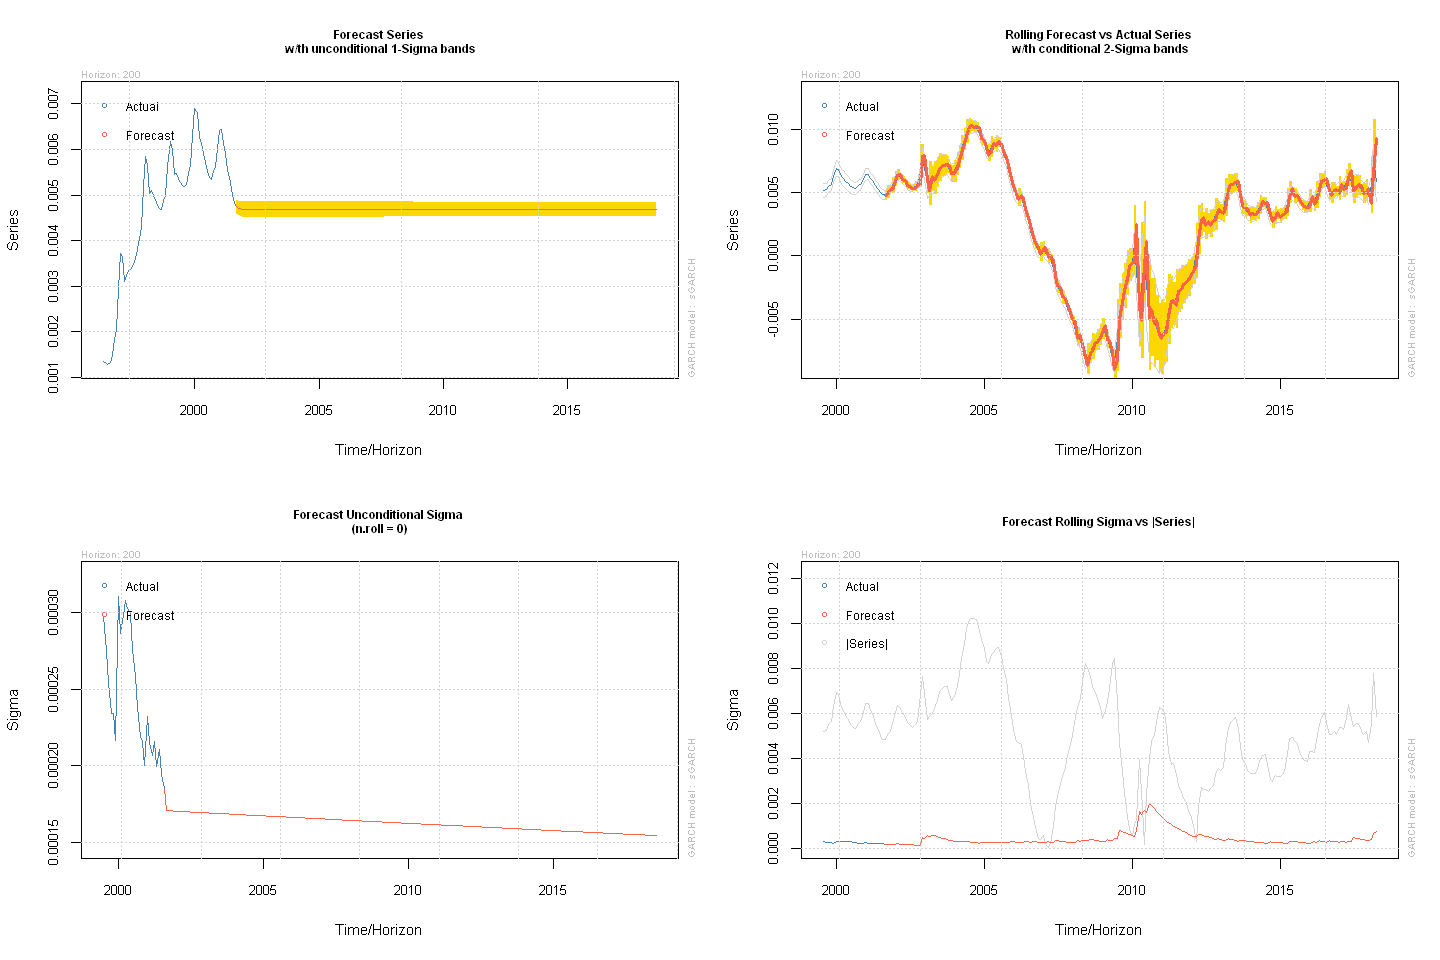

In [65]:
# Looking at yet another method of visualizing model performance, we can see that the rolling
# forecasts after each period, with a model refit each time, has been mostly successful at
# creating confidence bands around the last 60 months that contained the actual value, with the
# exception of the very last recorded month, where even an expanded band showing the influence
# of some conditional variance, the actual value fell beneath the confidence band.
ugfore <- ugarchforecast(fixedspec, ts1, n.ahead=200, n.roll=200, out.sample=200)
plot(ugfore, which='all')

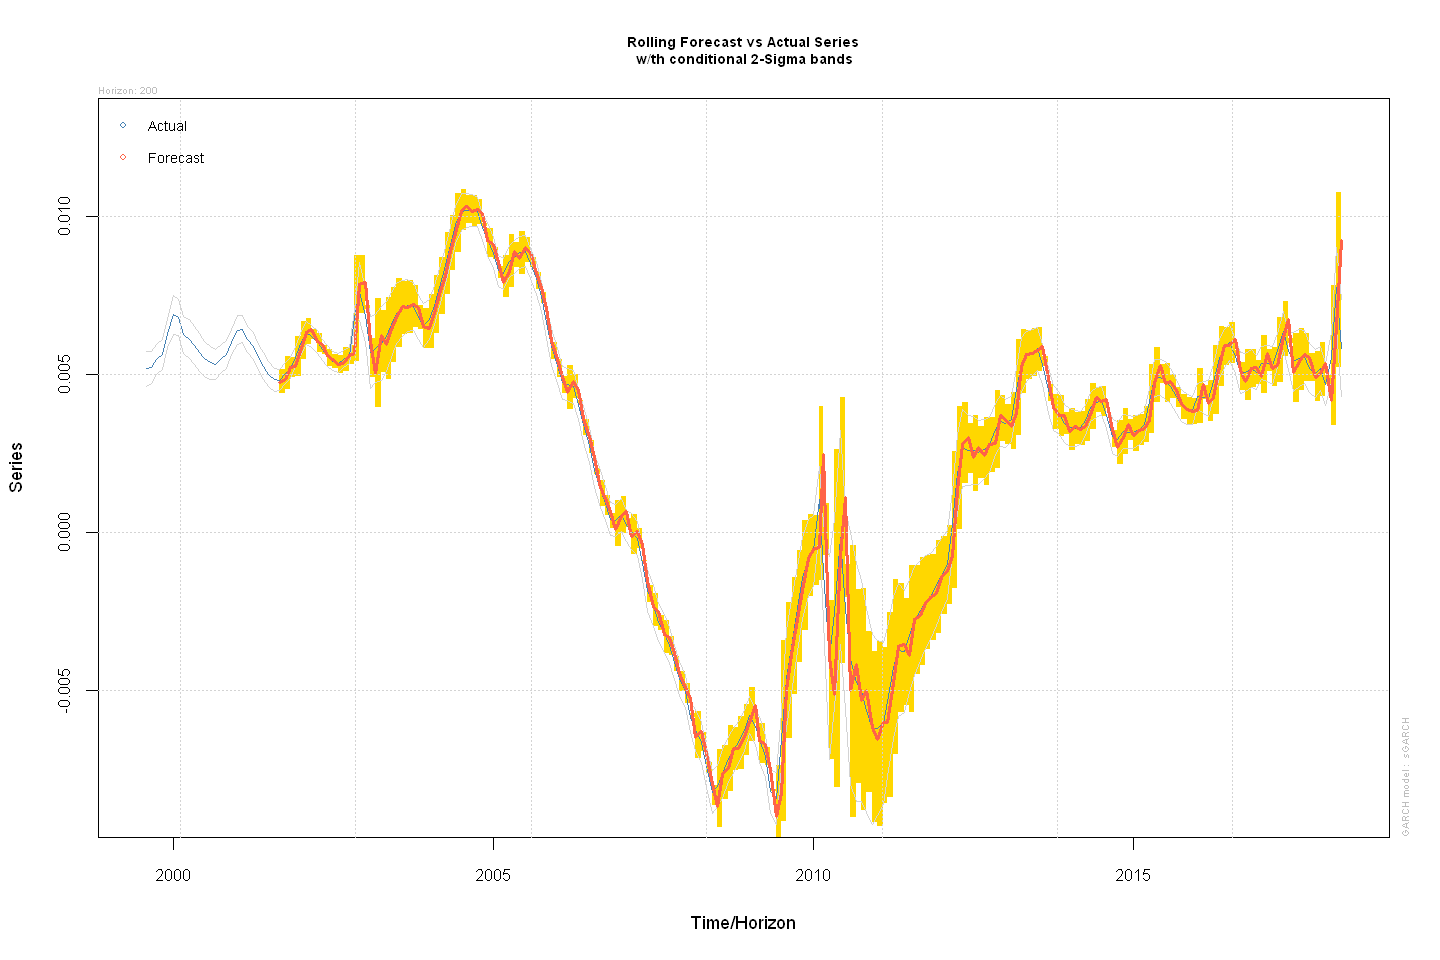

In [66]:
plot(ugfore, which=2)

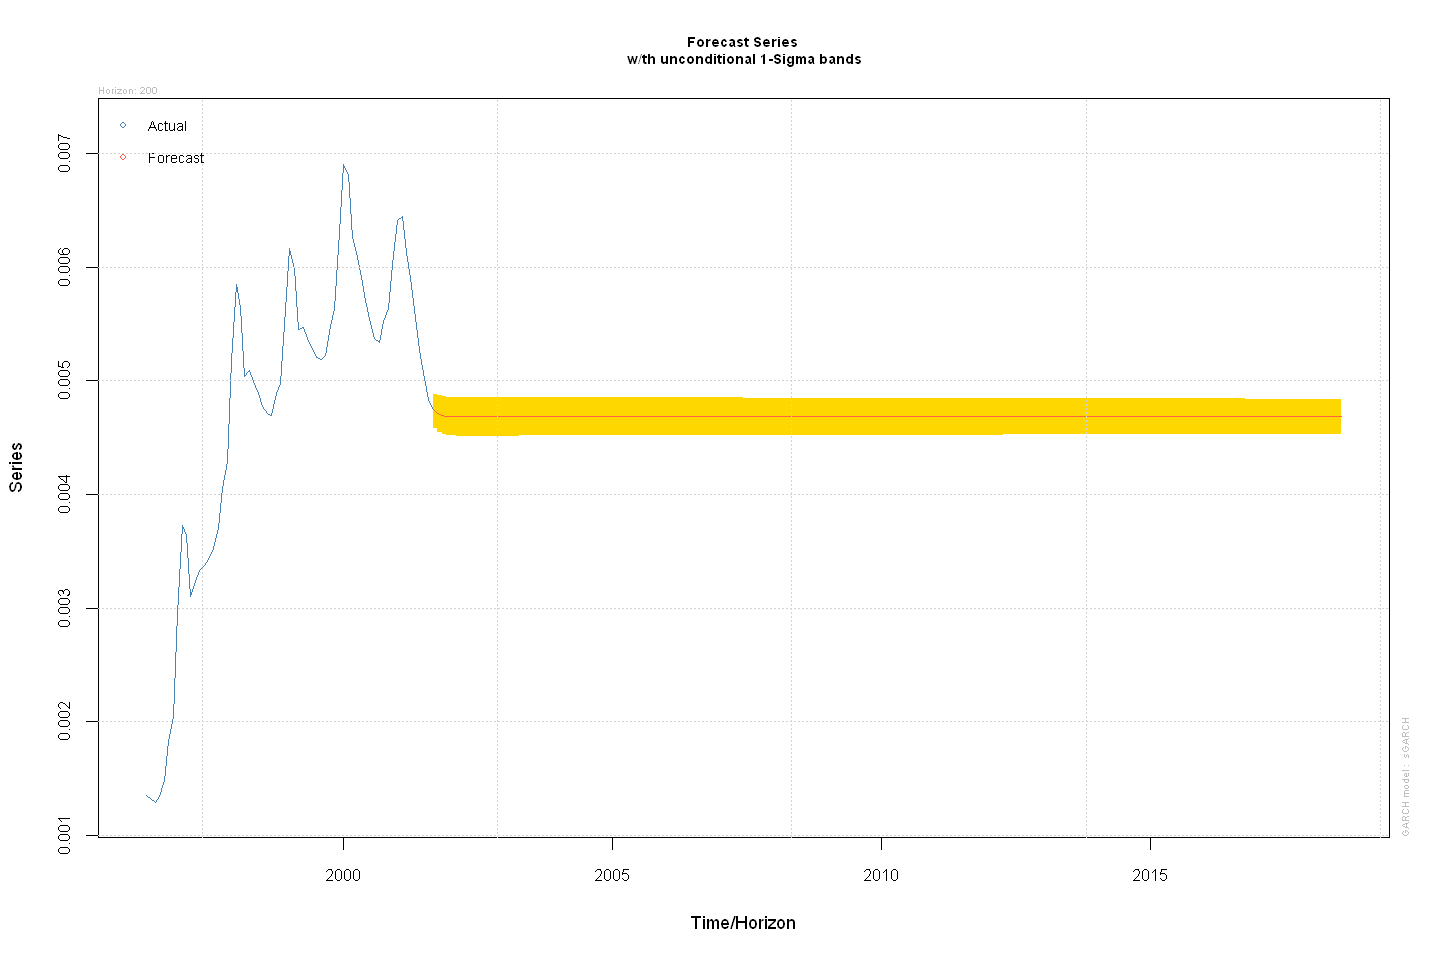

In [67]:
# We can see that unlike the forecast package, the ahead forecasts keep a constant variance,
# and do not reflect increasing uncertainty with time
plot(ugfore, which=1)

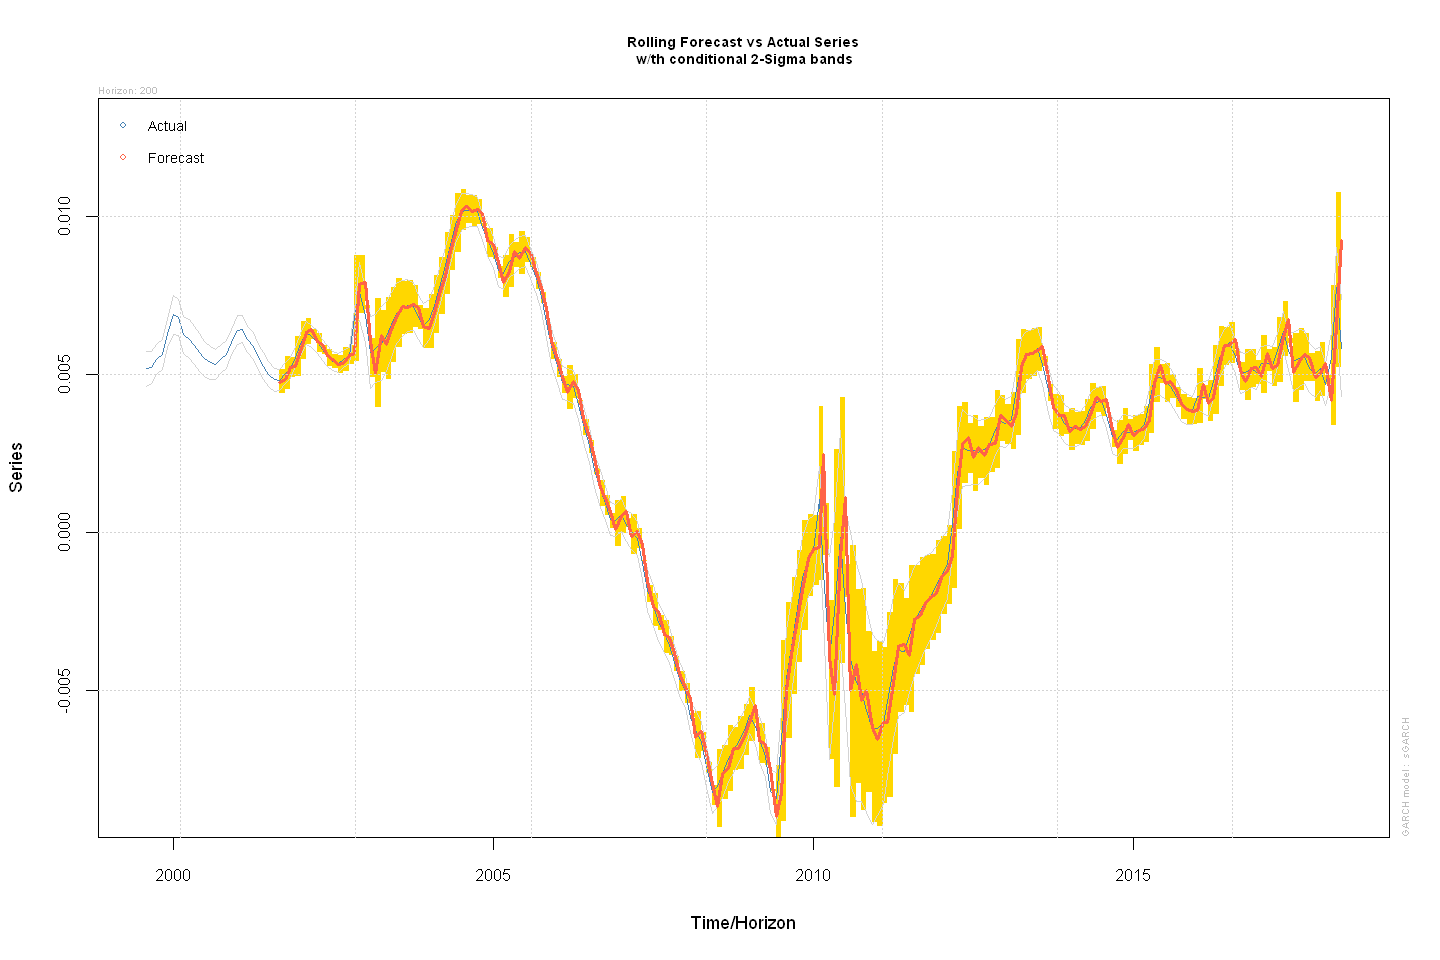

In [68]:
# Another look at the rolling forecast over the last 60 periods:
plot(ugfore, which=2)

In [69]:
# We can see that the real strength in this model is not the n ahead forecasts, but the size of
# the confidence band around the next prediction, which increases when volatility is present.

In [70]:
ugfore <- ugarchforecast(fit, n.ahead=2)

In [71]:
ugfore


*------------------------------------*
*       GARCH Model Forecast         *
*------------------------------------*
Model: sGARCH
Horizon: 2
Roll Steps: 0
Out of Sample: 0

0-roll forecast [T0=2018-04-01]:
      Series    Sigma
T+1 0.003485 0.001496
T+2 0.002473 0.001496



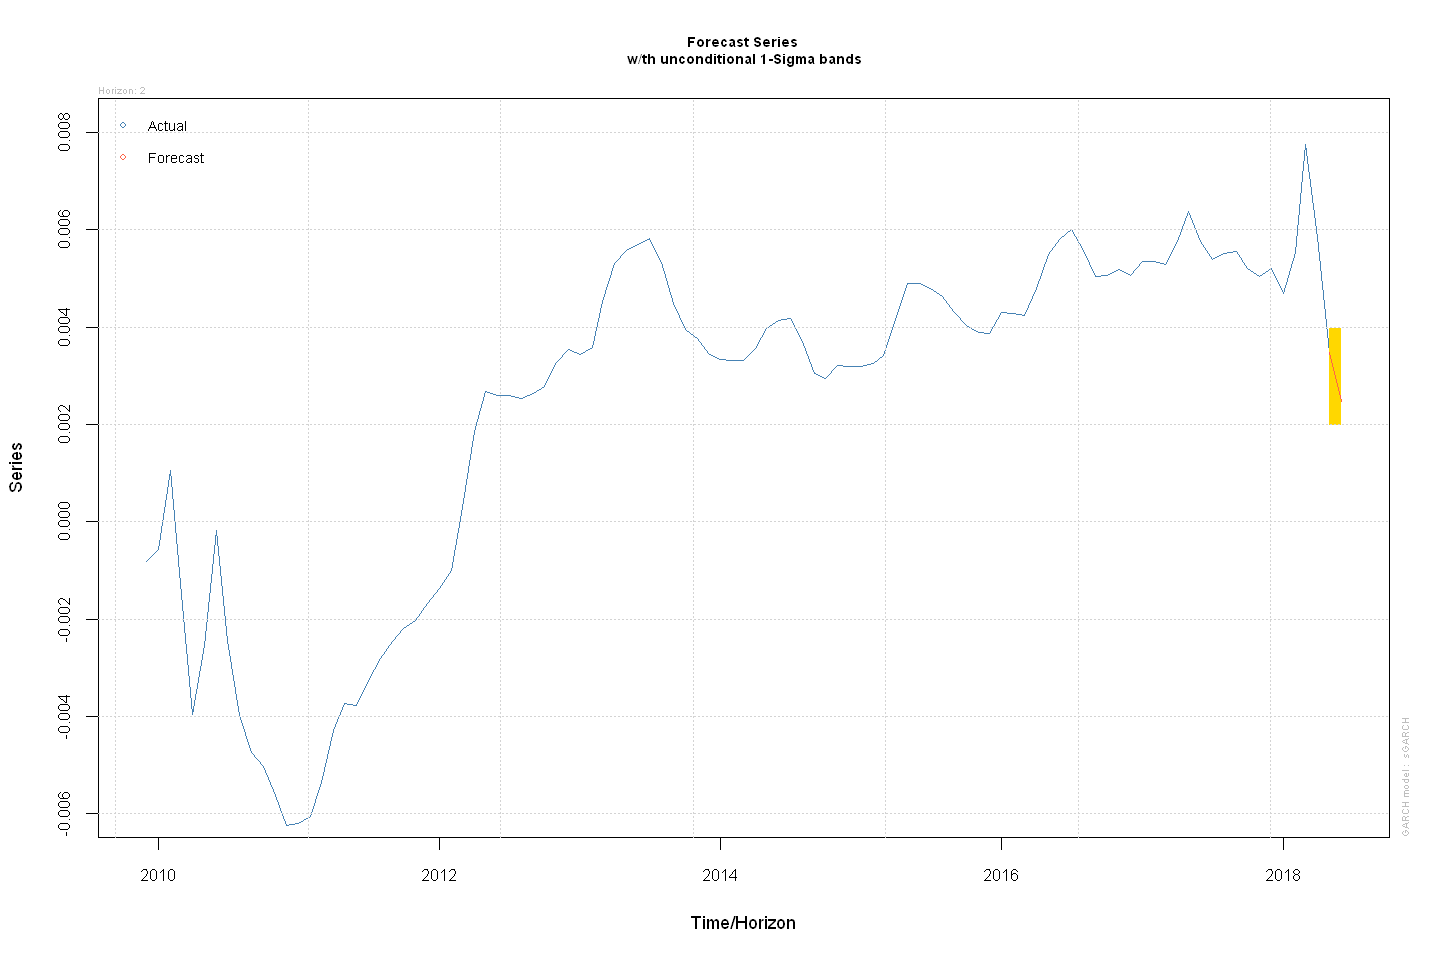

In [72]:
plot(ugfore, which=1)

In [501]:
ts3 <- copy(ts1)

In [502]:
head(ts3)

                   [,1]
1996-05-01 0.0010131971
1996-06-01 0.0009991636
1996-07-01 0.0009751320
1996-08-01 0.0010713327
1996-09-01 0.0012391198
1996-10-01 0.0016214530

In [505]:
lag(ts3, 1)

                    [,1]
1996-05-01            NA
1996-06-01  0.0010131971
1996-07-01  0.0009991636
1996-08-01  0.0009751320
1996-09-01  0.0010713327
1996-10-01  0.0012391198
1996-11-01  0.0016214530
1996-12-01  0.0018856534
1997-01-01  0.0028425900
1997-02-01  0.0036377804
1997-03-01  0.0035150544
1997-04-01  0.0029189971
1997-05-01  0.0030685798
1997-06-01  0.0031921350
1997-07-01  0.0032596971
1997-08-01  0.0032983070
1997-09-01  0.0034531241
1997-10-01  0.0036349513
1997-11-01  0.0040113532
1997-12-01  0.0042762482
1998-01-01  0.0052043207
1998-02-01  0.0058552499
1998-03-01  0.0056633285
1998-04-01  0.0050129185
1998-05-01  0.0051024305
1998-06-01  0.0050652031
1998-07-01  0.0050322018
1998-08-01  0.0049759053
1998-09-01  0.0049858588
1998-10-01  0.0050369869
1998-11-01  0.0052955905
1998-12-01  0.0054624550
1999-01-01  0.0062145164
1999-02-01  0.0067990795
1999-03-01  0.0065931686
1999-04-01  0.0060599632
1999-05-01  0.0061807866
1999-06-01  0.0061874970
1999-07-01  0.0062311750


In [39]:
args(ugarchboot)

function (fitORspec, data = NULL, method = c("Partial", "Full"), 
    sampling = c("raw", "kernel", "spd"), spd.options = list(upper = 0.9, 
        lower = 0.1, type = "pwm", kernel = "normal"), n.ahead = 10, 
    n.bootfit = 100, n.bootpred = 500, out.sample = 0, rseed = NA, 
    solver = "solnp", solver.control = list(), fit.control = list(), 
    external.forecasts = list(mregfor = NULL, vregfor = NULL), 
    mexsimdata = NULL, vexsimdata = NULL, cluster = NULL, verbose = FALSE) 
NULL

In [109]:
nrow(ts1)

[1] 264

In [122]:
bootp = ugarchboot(fixedspec, ts2, method=c('Partial', 'Full')[2], n.ahead=1,
                   #n.bootfit=nrow(ts1),
                   #n.bootpred=500,
                   rseed = matrix(c(1:600))
                  )

Warning message in .sgarchpath1(spec = spec, n.sim = n.sim, n.start = n.start, m.sim = m.sim, :
"
ugarchpath-->warning: n.start>=MA order for arfima model...automatically setting."


ERROR: Error in .custzdist(custom.dist, zmatrix, m.sim, n): row dimension
				of custom innovations
 matrix must be equal to n.sim+n.start


In [74]:
length(c(1:120))

[1] 120

In [92]:
matrix(c(1:120))

1
2
3
4
5
6
7
8
9
10
11
